## Trabalho 2 - Avaliação e Desempenho

---

**Alunos**:



Gabriel Christo - 117217732

Yago Alves - 115212477

Yuri Medeiros - 117061898

---

In [71]:
!pip install igraph
import random
import math
from pprint import pprint
from math import isclose
from collections import deque
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import scipy
import numpy as np
from scipy.stats import expon
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from scipy.optimize import fsolve
from scipy.optimize import root
import numpy as np
#!pip install igraph

#import networkx as nx


In [ ]:
# Constantes
discipline = "FCFS"
ARRIVAL = 0
END_OF_SERVICE = 1
MU = 1.0
IDLE = 0
BUSY = 1
FIFO = 0
LIFO = 1

N_RODADAS = 100
MIN_CLIENTES = 2500

T_PERCENTILE = 1.960 # alpha = 0.05

# Definição dos tempos exponencias


In [ ]:
def generate_exp(lambda_param):
  u0 = random.random() # Gera a variavel aleatoria uniforme no intervalo [0.0, 1.0)
  x0 = - math.log(u0) / lambda_param # Pega amostra da exponencial
  return x0

def exp10():
    return generate_exp(1.0)

def exp20():
    return generate_exp(2.0)

def exp40():
    return generate_exp(4.0)

def mu_exp10():
  return generate_exp(1.0)

def lambda_exp105(): #lambda
  return generate_exp(1.05)

def lambda_exp110():
  return generate_exp(1.10)


#Definição dos tempos determinístico


In [ ]:
# cenario 1
def t_determinist_cenario_1():
  return (1.0 / 2)

# cenario 2
def t_determinist_cenario_2():
	return (1.0 / 4)

# cenario 3
def t_determinist_cenario_3():
  return 1.0 /1

# cenario 4
def t_determinist_cenario_4():
  return 1.0 / 1

# Simulacao - classes e estimadores


In [ ]:
import queue

class Event:
    def __init__(self, event_type, ocurrence_time, client_id):
        self.event_type = event_type # Chegada ou fim de serviço
        self.t = ocurrence_time # Instante que o evento ocorre
        self.client_id = client_id # ID do cliente ao qual o evento esta relacionado


    def __lt__(self, other):
        return self.t < other.t


  # Define como a classe vai ser impressa
    def __repr__(self) -> str:
        if self.event_type == ARRIVAL:
            type_str = "ARRIVAL"
        else:
            type_str = "END_OF_SERVICE"
        return f"event_type: {type_str}\nt: {self.t}\nclient_id: {self.client_id}"

class EventsList:
  def __init__(self):
    self.events = queue.PriorityQueue()
  def add(self, event):
    self.events.put(event)
  def pop(self):
    # Pega o evento que ocorre mais cedo, já que a lista esta ordenada pelos tempos
    return self.events.get()

  def clear(self):
    self.events.queue.clear()

def get_event_time(event):
  return event.t

In [ ]:
class Client:
    def __init__(self, arrival_event):
        self.id = arrival_event.client_id
        self.arrival_time = arrival_event.t
        self.waiting_time = 0.0
        self.service_time = 0.0

    def __repr__(self) -> str:
        return f"Client ID: {self.id}\nArrival Time: {self.arrival_time}\nWaiting Time: {self.waiting_time}"


def create_client(event):
  new_client = Client(event)
  return new_client

class ClientsQueue:
  def __init__(self):
    self.clients = deque([])
  def add(self, client):
    self.clients.append(client)
  def pop(self):
      return self.clients.popleft()
  def clear(self):
    self.clients.clear()


def serve_client(client, t, service_dist, events_list):
  # Registra o tempo de espera do serviço
  client.waiting_time = t - client.arrival_time
  # Cria evento do fim do serviço
  end_of_service_event = generate_end_of_service(t, service_dist, client.id)
  client.service_time = end_of_service_event.t - (client.arrival_time + client.waiting_time)
  # Adiciona evento do fim do servico a lista de eventos
  events_list.add(end_of_service_event)

In [ ]:
def generate_arrival(start_time, arrival_dist, client_id):
  arrival = Event(ARRIVAL, start_time + arrival_dist(), client_id)
  return arrival

def generate_end_of_service(t, service_dist, client_id):
  end_of_service = Event(END_OF_SERVICE, t + service_dist(), client_id)
  return end_of_service

In [ ]:

class Estimator:
  def __init__(self):
    self.samples_list = [] # amostras
    self.samples_sum = 0.0 # Soma das amostras
    self.squares_sum = 0.0 # Soma dos quadrados das amostras
    self.n = 0 # Numero de amostras
  def add_sample(self, sample):
    self.samples_list.append(sample)
    self.samples_sum += sample
    self.squares_sum += (sample**2)
    self.n += 1
  def get_samples_list(self):
    return self.samples_list
  def mean(self):
    return self.samples_sum / self.n
  def variance(self):
    term1 = self.squares_sum / (self.n - 1)
    term2 = (self.samples_sum**2) / (self.n * (self.n - 1))
    return term1 - term2
  def set_sample_list(self, sample_list):
    self.samples_list = sample_list
    self.samples_sum = sum(sample_list)
    self.squares_sum = sum([sample**2 for sample in sample_list])
    self.n = len(sample_list)
  def tstudent_ci(self):
    # import pdb
    # pdb.set_trace()
    term = T_PERCENTILE * (math.sqrt(abs(self.variance()))/math.sqrt(N_RODADAS))
    # TRAB2: adicionamos o abs
    return self.mean() - term, self.mean() + term
  def clear(self):
    self.samples_sum = 0.0
    self.samples_list = []
    self.squares_sum = 0.0
    self.n = 0

class NqueueAreaEstimator:
  def __init__(self):
    # Soma das areas
    self.nqueue_area_sum = 0.0
    # Soma dos intervalos de tempo
    self.dt_sum = 0.0
  def add_sample(self, nqueue, dt):
    self.nqueue_area_sum += nqueue * dt
    self.dt_sum += dt
  def mean(self):
    return self.nqueue_area_sum / self.dt_sum
  def clear(self):
    self.nqueue_area_sum = 0.0
    self.dt_sum = 0.0

class NqueuePmfEstimator:
  def __init__(self):
    # Soma dos quadrados dos Nqis coletados vezes o intervalo de tempo
    self.nqueue_squares_sum = 0.0
    # Soma dos Nqis coletados vezes o intervalo de tempo
    self.nqueue_sum = 0.0
    # Soma dos intervalos de tempo
    self.dt_sum = 0.0
  def add_sample(self, nqueue, dt):
    self.nqueue_squares_sum += (nqueue**2) * dt
    self.nqueue_sum += nqueue * dt
    self.dt_sum += dt
  def variance(self):
    second_moment = self.nqueue_squares_sum / self.dt_sum
    first_moment = self.nqueue_sum / self.dt_sum
    return second_moment - (first_moment**2)
  def clear(self):
    self.nqueue_squares_sum = 0.0
    self.nqueue_sum = 0.0
    self.dt_sum = 0.0

#Prints

In [ ]:
tempos_espera = 0

def print_CDF(num_clientes,tempos_espera):

  tempos_espera = np.sort(tempos_espera)
  cdf = np.arange(1, len(tempos_espera) + 1) / len(tempos_espera)

  # plotando cdfs
  fig, axes = plt.subplots(1, 2, figsize=(14, 6))
  axes[0].plot(tempos_espera, cdf, marker='o')
  axes[0].set_xlabel('Tempo Médio de Espera')
  axes[0].set_ylabel('CDF')
  axes[0].set_title('CDF a partir dos Tempos Médios de Espera')
  axes[0].grid(True)

  num_clientes = np.sort(num_clientes)
  cdf_2 = np.arange(1, len(num_clientes) + 1) / len(num_clientes)

  axes[1].plot(num_clientes, cdf_2, marker='o')
  axes[1].set_xlabel('Quantidade média de clientes ao longo das rodadas')
  axes[1].set_ylabel('CDF')
  axes[1].set_title('CDF a partir da quantidade média de clientes')
  axes[1].grid(True)

  plt.show()


In [ ]:
def plotAll(
    time_est,
    time_var_est,
    nqueue_est,
    nqueue_var_est,
    empty_queue_estimator,
    discipline,
    W,
    Nq,
    W2, # redundante
    busy_time,
    estimador_cliente_tempo_total,
    estimador_cliente_tempo_servico
):


    # Obtem os intervalos de confiança e seus centros
    # utilizamos a t-student para calcular a
    # o ic da media de tempo, variancia do tempo, media de clientes na fila (Nq)
    # variancia de clientes na fila (Nq)
    w_mean_lower, w_mean_upper = time_est.tstudent_ci()
    w_mean_center = time_est.mean()

    w_var_lower2, w_var_upper2 = time_var_est.tstudent_ci()
    # w_var_center2 = time_var_est.mean()

    nq_mean_lower, nq_mean_upper = nqueue_est.tstudent_ci()
    # nq_mean_center = nqueue_est.mean()

    nq_var_lower2, nq_var_upper2 = nqueue_var_est.tstudent_ci()
    # nq_var_center2 = nqueue_var_est.mean()

    # sistema atingindo estado zero
    low, up = empty_queue_estimator.tstudent_ci()
    # mean = empty_queue_estimator.mean()

    # tempo clientes no sistema
    low_cl, up_cl = estimador_cliente_tempo_total.tstudent_ci()

    # tempo servico clientes
    low_cl_service, up_cl_service = estimador_cliente_tempo_servico.tstudent_ci()

    # grafico das amostras de Wplt.subplots(3, 2, figsize=(10, 12))
    # grafico das amostras de W
    fig, axes = plt.subplots(4, 2, figsize=(12, 14), dpi=100)

    axes[0][0].hist(
        time_est.get_samples_list(),
        density=True,
        color="lightgrey",
        edgecolor="darkgrey",
        bins="scott",
    )
    axes[0][0].set_xlabel("Amostras E(W)")
    axes[0][0].set_ylabel("Densidade")
    axes[0][0].set_title("Média da média de W por rodadas/ Densidade Amostral")
    axes[0][0].grid(True)

    axes[0][1].hist(
        nqueue_est.get_samples_list(),
        density=True,
        color="lightgrey",
        edgecolor="darkgrey",
        bins="scott",
    )
    axes[0][1].set_xlabel("Amostras E(Nq)")
    axes[0][1].set_ylabel("Densidade")
    axes[0][0].set_title("Média da média de Nq por rodadas/ Densidade Amostral")
    axes[0][1].grid(True)

    tempo_servindo_values = [item["tempo_servindo"] for item in busy_time]
    axes[1][0].hist(
        tempo_servindo_values,
        bins=30,
        edgecolor="darkgrey",
    )
    axes[1][0].set_xlabel("TEMPO DE SERVICO")
    axes[1][0].set_ylabel("densidade")
    axes[1][0].grid(True)

    # densidade x clientes
    axes[1][1].hist(
        np.sort(W),
        bins=30,
        edgecolor="darkgrey",
    )
    axes[1][1].set_xlabel("E(W)")
    axes[1][1].set_ylabel("densidade")
    axes[1][1].grid(True)

    # tempo total dos clientes no sistema (fila + serviço)
    axes[2][0].hist(
        estimador_cliente_tempo_total.get_samples_list(),
        bins="scott",
        edgecolor="darkgrey",
    )
    axes[2][0].set_xlabel("tempo total clientes no sistema")
    axes[2][0].set_ylabel("densidade")
    axes[2][0].grid(True)

    # tempo de serviço dos clientes no sistema
    axes[2][1].hist(
        estimador_cliente_tempo_servico.get_samples_list(),
        bins="scott",
        edgecolor="darkgrey",
    )
    axes[2][1].set_xlabel("tempo de serviço clientes no sistema")
    axes[2][1].set_ylabel("densidade")
    axes[2][1].grid(True)


    axes[3][1].plot(W, label=f"'FIFO' - ρ = colocar o rô aqui")
    axes[3][1].set_title("Gráfico da transiente - E[W]")
    axes[3][1].set_xlabel("Rodadas")
    axes[3][1].set_ylabel("E[W]")
    axes[3][1].grid(True)


    axes[3][0].plot(Nq, label=f"'FIFO' - ρ = colocar o rô aqui")
    axes[3][0].set_title("Gráfico da transiente - E[Nq]")
    axes[3][0].set_xlabel("Rodadas")
    axes[3][0].set_ylabel("E[Nq]")
    axes[3][0].grid(True)

    # numero de clientes na fila
    plt.figure(num=3, figsize=(8, 5), dpi=100)
    tmp = []
    for i in range(N_RODADAS): # MIN_CLIENTES
        for item in n_clients_list[i]:
            tmp.append(item)
    plt.plot(tmp, label=f"Numero de clientes de fila")
    plt.title("Numero de clientes de fila")
    plt.xlabel("ciclos")
    plt.ylabel("#Clientes")
    plt.grid(True)
    fig.tight_layout(pad=5.0)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.scatter(
        range(0, len(empty_queue_estimator.get_samples_list())),
        empty_queue_estimator.get_samples_list(),
    )
    plt.xlabel("RodadaS")
    plt.ylabel("# de vezes que sistema atinge estado zero")
    plt.show()

    print_CDF(Nq, W)

    print("Média de W")  # W :  Tempo de espera na fila
    print(f"IC: {w_mean_lower:.3f} a {w_mean_upper:.3f}")
    print("Variância de W")
    print(f"IC: {w_var_lower2:.3f} a {w_var_upper2:.3f}\n")
    print("Média de Nq")  # Nq : numero clientes na fila
    print(f"IC: {nq_mean_lower:.3f} a {nq_mean_upper:.3f}")
    print("Variância de Nq")
    print(f"IC: {nq_var_lower2:.3f} a {nq_var_upper2:.3f}\n")
    print("Média de vezes que sistema atinge estado zero por rodada")
    print(f"IC: {low:.3f} a {up:.3f}\n")
    print("Média de tempo total dos clientes no sistema")
    print(f"IC: {low_cl:.3f} a {up_cl:.3f}\n")
    print("Média de tempo de serviço dos clientes no sistema")
    print(f"IC: {low_cl_service:.3f} a {up_cl_service:.3f}\n")


    print(f"\n[CORRETUDE] Calculando a Lei de little com base nos estimadores de")
    print("[CORRETUDE] media de tempo na fila/ media de tempo total  =  lambda")
    print(
        f"[CORRETUDE] Littles Law: {nqueue_est.mean()/estimador_cliente_tempo_total.mean()}\n"
    )  # tem que dar igual o lambda
#
#     return {
#         "time_mean": [discipline, w_mean_lower, w_mean_upper, w_mean_center],
#         "time_var_t": [discipline, w_var_lower2, w_var_upper2, w_var_center2],
#         "nqueue_mean": [discipline, nq_mean_lower, nq_mean_upper, nq_mean_center],
#         "nqueue_var_t": [discipline, nq_var_lower2, nq_var_upper2, nq_var_center2],
#         "time_graph_values": W,
#         "nqueue_graph_values": Nq,
#     }


#Simulador Trabalho 1

In [ ]:
n_clients_list = []
estimador_tempo_total = Estimator()
estimador_tempo_ocioso = Estimator()
estimador_tempo_servindo = Estimator()
estimador_cliente_tempo_total = Estimator()
estimador_cliente_tempo_servico = Estimator()

def simulate(rounds, round_size, arrival_dist, service_dist):
    # estimadores
    media_tempo_por_rodada = []

    # Estimadores de tempo de espera e tamanho da fila
    time_est = Estimator()
    nqueue_est = Estimator()

    # Estimadores da variancia pela t-student
    time_var_est = Estimator()
    nqueue_var_est = Estimator()

    empty_queue_estimator = Estimator()

    W = []  # lista com os valores do estimador de E[W] ao longo do tempo
    Nq = []  # lista com numeros de individuos na fila em cada rodada

    empty_queue_ocurrences = 0
    busy_time = []

    # start up sistema
    t = 0.0
    nqueue = 0
    cliente_sendo_servido = None

    ## sistema começa com 1 chegada
    client_id = 0
    first_arrival = generate_arrival(
        start_time=t, arrival_dist=arrival_dist, client_id=client_id
    )
    events_list = EventsList()
    events_list.add(first_arrival)
    clients_queue = ClientsQueue()  # fila de espera
    client_id += 1

    for i in range(rounds):
        #print(f'\nCOMEÇANDO RODADA {i} da simulação')

        served_clients = 0
        # Inicia os estimadores de tempo de espera e tamanho da fila da rodada
        round_time_est = Estimator()
        round_nqueue_est = NqueueAreaEstimator()
        round_nqueue_pmf_est = NqueuePmfEstimator()

        nqueue = 0  # zerando tamanho da fila

        n_clientes_por_rodada = []

        # metricas de nascimento e morte
        servidor_ocioso = False
        ciclos_ociosos = 0
        tempo_periodo_ocioso = 0
        inicio_periodo_ocioso = 0  # tempo da ultima morte
        busy_time_counter = 0

        while (
            served_clients < round_size
        ):  # round size é o minimo de clientes atendidos
            #print(
            #    f"\nNew Round\n{served_clients} de  {round_size}\nEventos na fila de espera: {nqueue}"
            #)

            event = events_list.pop()
            round_nqueue_est.add_sample(
                # se tivermos um cliente sendo atendido somamos mais um no numero de clientes no sistema
                nqueue if cliente_sendo_servido == None else nqueue + 1,
                event.t - t,
            )
            round_nqueue_pmf_est.add_sample(nqueue, event.t - t)

            # Avança o tempo para o instante do evento
            t = event.t

            #print(f"tempo de simulação {t}\nEvento atual: \n{event}\n")
            if event.event_type == ARRIVAL:
                novo_cliente = create_client(event)

                if servidor_ocioso:
                    ciclos_ociosos += 1
                    tempo_periodo_ocioso += t - inicio_periodo_ocioso
                    servidor_ocioso = False

                if not cliente_sendo_servido:
                    cliente_sendo_servido = novo_cliente
                    serve_client(
                        novo_cliente, t, service_dist, events_list
                    )  # Registra tempo de espera e adiciona evento do fim do serviço na lista TODO: EXPLICAR MELHOR
                else:
                    clients_queue.add(novo_cliente)
                    nqueue += 1  # Incrementa numero de clientes na fila de espera

                nova_chegada = generate_arrival(
                    start_time=t, arrival_dist=arrival_dist, client_id=client_id
                )
                client_id += 1
                events_list.add(nova_chegada)
            else:
                served_clients += 1
                #print(f"service time do {cliente_sendo_servido.id} : {cliente_sendo_servido.service_time}")
                #print(f"waiting time do {cliente_sendo_servido.id} : {cliente_sendo_servido.waiting_time}")

                round_time_est.add_sample(
                    cliente_sendo_servido.waiting_time
                )  # Salva o tempo de espera do cliente que acabou o serviço
                busy_time_counter += cliente_sendo_servido.service_time

                estimador_cliente_tempo_total.add_sample(
                    cliente_sendo_servido.waiting_time
                    + cliente_sendo_servido.service_time
                )

                estimador_cliente_tempo_servico.add_sample(
                    cliente_sendo_servido.service_time
                )

                if nqueue == 0:
                    #print("[*****] Fila de espera vazia")
                    cliente_sendo_servido = None

                    empty_queue_ocurrences += 1
                    inicio_periodo_ocioso = t
                    servidor_ocioso = True
                else:
                    # caso a fila de espera nao esteja vazia, pegamos o proximo
                    client = clients_queue.pop()
                    cliente_sendo_servido = client
                    serve_client(
                        client, t, service_dist, events_list
                    )  # Registra tempo de espera e adiciona evento do fim do serviço na lista

                    nqueue -= 1  # Decrementa numero de clientes na fila de espera

            n_clientes_por_rodada.append(nqueue)

        # estimadores por rodada
        estimador_tempo_total.add_sample(t)
        estimador_tempo_ocioso.add_sample(tempo_periodo_ocioso)
        estimador_tempo_servindo.add_sample(busy_time_counter)
        busy_time.append(
            {
                "tempo_sistema": t,
                "tempo_ocioso": tempo_periodo_ocioso,
                "qtd_ciclos_ociosos": ciclos_ociosos,
                "tempo_servindo": busy_time_counter,
            }
        )

        n_clients_list.append(n_clientes_por_rodada)

        # print(f'Fracao periodo ocupado: {ciclos_ociosos}')
        # print(f'Tempo Ocioso do sistema: {tempo_periodo_ocioso}')
        inicio_periodo_ocioso = 0  # death_time
        # checa se o sistema ocupado
        # print(f'empty_queue_ocurrences:: {empty_queue_ocurrences}')
        ###

        # salvando numero de vezes que sistema atingiu estado zero na rodada atual
        empty_queue_estimator.add_sample(empty_queue_ocurrences)
        empty_queue_ocurrences = 0

        # zerando tempo de simulação e lista de eventos/clientes para próxima rodada
        cliente_sendo_servido = None
        client_id = 0
        t = 0
        clients_queue.clear()
        events_list.clear()
        events_list.add(generate_arrival(t, arrival_dist, client_id))
        client_id += 1

        # Calcula a estatisticas de W e Nq da rodada (amostras da rodada)
        round_time_mean = round_time_est.mean()
        round_time_var = round_time_est.variance()
        round_nqueue_mean = round_nqueue_est.mean()
        round_nqueue_var = round_nqueue_pmf_est.variance()

        # Salva as amostras da rodada nos estimadores gerais
        time_est.add_sample(round_time_mean)
        time_var_est.add_sample(round_time_var)
        nqueue_est.add_sample(round_nqueue_mean)
        nqueue_var_est.add_sample(round_nqueue_var)

        # zerando estimadores
        round_time_est.clear()
        round_nqueue_est.clear()
        round_nqueue_pmf_est.clear()

        # Salva amostras para o grafico, se desejado
        media_tempo_por_rodada.append(round_time_mean)
        W.append(time_est.mean())
        Nq.append(nqueue_est.mean())

    plotAll(
        time_est,
        time_var_est,
        nqueue_est,
        nqueue_var_est,
        empty_queue_estimator,
        discipline,
        W,
        Nq,
        media_tempo_por_rodada,
        busy_time,
        estimador_cliente_tempo_total,
        estimador_cliente_tempo_servico
    )

    total_qtd_ciclos_ociosos = sum(item["qtd_ciclos_ociosos"] for item in busy_time)
    print(f'Total de ciclos ocupados {(N_RODADAS * MIN_CLIENTES - total_qtd_ciclos_ociosos)}')
    print(f'Fração de ciclos ocupados {(N_RODADAS * MIN_CLIENTES - total_qtd_ciclos_ociosos)/N_RODADAS* MIN_CLIENTES}')

    print(f'Total de periodos ociosos: {(total_qtd_ciclos_ociosos)}')

    print(f'Fração de periodos ociosos: {(total_qtd_ciclos_ociosos)/N_RODADAS*MIN_CLIENTES}')

   #pprint(busy_time)


#Graph Analysis


In [81]:
estimador_grau_medio_saida_raiz = Estimator() # estimador grau médio de saída da raiz
estimador_grau_medio_maximo_saida = Estimator()
estimador_grau_medio_saida_nos = Estimator() # estimador auxiliar grau médio de saída dos nós
estimador_altura_media_arvore = Estimator() # estimador Qual a altura média da árvore?
estimador_media_altura_nos = Estimator()
estimador_media_duracao_periodo_ocupado = Estimator()
estimador_clientes_por_arvore = Estimator()

estimador_arvores_inifnitas = Estimator()
arvores_inf_contador = []
arvores_fin_contador = []

todas_as_arvores = []

def graph_analysis(G, print_tree = False):

    if print_tree:
      nx.draw(G, pos=nx.planar_layout(G), with_labels=True, node_size=500, node_color='skyblue', font_size=12, font_color='black', arrows=True)
      plt.show()

    G1 = ig.Graph.from_networkx(G)

    # componentes fracamente conexos de uma floresta
    components = nx.weakly_connected_components(G)
    components_i = G1.decompose(mode = "weak")

    tree_heights = []

    # Altura media da arvore
    for component in components_i:
        subgraph = component
        if subgraph.is_tree():
            height = 0
            caminhos = subgraph.path_length_hist()
            for item in list(caminhos.bins()):
              if item[1] > height: height = item[1]

            estimador_media_altura_nos.add_sample(caminhos.mean)
            estimador_clientes_por_arvore.add_sample(len(subgraph.vs))

            #print(height)
            tree_heights.append(height)

    estimador_altura_media_arvore.add_sample(sum(tree_heights)/len(tree_heights))

    # Grau medio de saida dos nos
    max_tree_degree = 0
    for component in components_i:
        subgraph = component
        if subgraph.is_tree():
            max_degree = max(G1.degree())
            #print(max_degree)
            # Atualiza o max_degree da arvore se for o caso
            if max_degree > max_tree_degree:
                max_tree_degree = max_degree

    estimador_grau_medio_saida_nos.add_sample(max_tree_degree)

    # Grau medio de saida da raiz
    root_degrees = []
    for node in G.nodes():
        if "raiz" in str(node):
            root_degrees.append(G.degree(node))

    estimador_grau_medio_saida_raiz.add_sample(sum(root_degrees)/len(root_degrees))

    # Grau medio maximo de saida
    grau_max = 0
    for i in G.nodes:
        if G.degree(i) > grau_max:
            grau_max = G.degree(i)
    estimador_grau_medio_maximo_saida.add_sample(grau_max)
    #print(f'Grau maximo do grafo: {grau_max}')

    grau_medio_saida_nos = 0
    for i in G.nodes:
        grau_medio_saida_nos += G.degree(i)
    grau_medio_saida_nos = grau_medio_saida_nos / len(G.nodes)
    estimador_grau_medio_saida_nos.add_sample(grau_medio_saida_nos)

    #print("Grafo do sistema")
    #print(G.nodes)

    if print_tree:

      # Pega os graus de saida
      out_degrees = [G.out_degree(n) for n in G.nodes()]
      #print(out_degrees)

      hist, bin_edges = np.histogram(out_degrees, bins=range(0, max(out_degrees)+2), density=True)
      plt.hist(out_degrees, bins=range(0, max(out_degrees)+2), edgecolor='black')
      plt.xlabel('Out-degree')
      plt.ylabel('Frequency')
      plt.title('Histogram of Out-degrees')
      plt.show()

      # calcula a PDF
      pdf = hist / sum(hist)

      media = 0
      for value, prob in zip(pdf, bin_edges[1:] - 1):
        media += value * prob
      print('Média da distribuição dos graus de saída (mu): ', media)

      plt.plot(bin_edges[1:] - 1, pdf)
      plt.xlabel('Out-degree')
      plt.ylabel('PDF')
      plt.title('PDF of Out-degree')
      plt.show()

      # Pega a CDF
      cdf = np.cumsum(pdf)

      # Plota a cdf
      plt.plot(bin_edges[1:] -1, cdf, marker='o')
      plt.xlabel('Out-degree')
      plt.ylabel('CDF')
      plt.title('CDF of Out-degree')
      plt.show()

    #max_nodes = MIN_CLIENTES
    for component in components_i:
        todas_as_arvores.append(component)



# Simulador Trabalho 2


In [78]:
n_clients_list = []
estimador_tempo_total = Estimator()
estimador_tempo_ocioso = Estimator()
estimador_tempo_servindo = Estimator()
estimador_cliente_tempo_total = Estimator()
estimador_cliente_tempo_servico = Estimator()

def simulate_trab2(rounds, round_size, arrival_dist, service_dist):
    # estimadores
    media_tempo_por_rodada = []

    # Estimadores de tempo de espera e tamanho da fila
    time_est = Estimator()
    nqueue_est = Estimator()

    # Estimadores da variancia pela t-student
    time_var_est = Estimator()
    nqueue_var_est = Estimator()

    empty_queue_estimator = Estimator()

    W = []  # lista com os valores do estimador de E[W] ao longo do tempo
    Nq = []  # lista com numeros de individuos na fila em cada rodada

    empty_queue_ocurrences = 0
    busy_time = []

    # start up sistema
    t = 0.0
    nqueue = 0
    cliente_sendo_servido = None

    ## sistema começa com 1 chegada
    client_id = 0
    first_arrival = generate_arrival(
        start_time=t, arrival_dist=arrival_dist, client_id=client_id
    )
    events_list = EventsList()
    events_list.add(first_arrival)

    # No raiz inicial
    G = nx.DiGraph()
    raiz_atual = str(client_id) + " (raiz)"
    G.add_node(raiz_atual)

    # variaveis para salvar tempos de cada periodo ocupado
    inicio_busy_period = 0
    contador_busy_period = 0

    clients_queue = ClientsQueue()  # fila de espera
    client_id += 1

    for i in range(rounds):
        #print(f"COMEÇANDO RODADA {i} da simulação")

        served_clients = 0
        # Inicia os estimadores de tempo de espera e tamanho da fila da rodada
        round_time_est = Estimator()
        round_nqueue_est = NqueueAreaEstimator()
        round_nqueue_pmf_est = NqueuePmfEstimator()

        nqueue = 0  # zerando tamanho da fila

        n_clientes_por_rodada = []

        # metricas de nascimento e morte
        servidor_ocioso = False
        ciclos_ociosos = 0
        tempo_periodo_ocioso = 0
        inicio_periodo_ocioso = 0  # tempo da ultima morte
        busy_time_counter = 0

        while (
            served_clients < round_size
        ):  # round size é o minimo de clientes atendidos
            #print(f"{served_clients} de  {round_size}")
            #print(
            #    f"\nNew Round\n{served_clients} de  {round_size}\nEventos na fila de espera: {nqueue}"
            # )
            event = events_list.pop()
            round_nqueue_est.add_sample(
                # se tivermos um cliente sendo atendido somamos mais um no numero de clientes no sistema
                nqueue if cliente_sendo_servido == None else nqueue + 1,
                event.t - t,
            )
            round_nqueue_pmf_est.add_sample(nqueue, event.t - t)

            # Avança o tempo para o instante do evento
            t = event.t

            #print(f"\ntempo de simulação {t}\nEvento atual: \n{event}\n")
            #print(G.nodes)
            if event.event_type == ARRIVAL:
                novo_cliente = create_client(event)

                if servidor_ocioso:
                    ciclos_ociosos += 1
                    tempo_periodo_ocioso += t - inicio_periodo_ocioso
                    servidor_ocioso = False
                    # se o servidor estiver ocioso a proxima chega é uma raiz
                    raiz_atual = str(event.client_id) + " (raiz)"
                    degree = G.degree(raiz_atual)
                    # print(f"Raiz: {raiz_atual} - {degree}")
                    # print(degree)
                    G.add_node(raiz_atual)
                    inicio_busy_period = t
                    #print(f'(EOS ID {event.client_id}) Tempo atual: {t}\t Inicio periodo ocupado: {inicio_busy_period}\t Contador periodo ocupado: {contador_busy_period}')


                if not cliente_sendo_servido:
                    cliente_sendo_servido = novo_cliente
                    serve_client(
                        novo_cliente, t, service_dist, events_list
                    )  # Registra tempo de espera e adiciona evento do fim do serviço na lista
                else:
                    clients_queue.add(novo_cliente)
                    nqueue += 1  # Incrementa numero de clientes na fila de espera
                    # se o servidor estiver ocupado, ou seja, o proximo cliente sera um filho do graph
                    G.add_edge(raiz_atual, event.client_id)
                    #{raiz1 = edge1,edge2,edge3}

                nova_chegada = generate_arrival(
                    start_time=t, arrival_dist=arrival_dist, client_id=client_id
                )
                client_id += 1
                events_list.add(nova_chegada)
            else:
                served_clients += 1
                # print(f"service time do {cliente_sendo_servido.id} : {cliente_sendo_servido.service_time}")
                # print(f"waiting time do {cliente_sendo_servido.id} : {cliente_sendo_servido.waiting_time}")

                round_time_est.add_sample(
                    cliente_sendo_servido.waiting_time
                )  # Salva o tempo de espera do cliente que acabou o serviço
                busy_time_counter += cliente_sendo_servido.service_time

                estimador_cliente_tempo_total.add_sample(
                    cliente_sendo_servido.waiting_time
                    + cliente_sendo_servido.service_time
                )

                estimador_cliente_tempo_servico.add_sample(
                    cliente_sendo_servido.service_time
                )

                if nqueue == 0:
                    # print("[*****] Fila de espera vazia")
                    cliente_sendo_servido = None

                    empty_queue_ocurrences += 1
                    inicio_periodo_ocioso = t
                    servidor_ocioso = True
                    # TRAB2: caso do servidor ocioso, tratamos no if de chegada

                    contador_busy_period = t - inicio_busy_period

                    #print(f'(EOS ID {event.client_id}) Tempo atual: {event.t}\t Inicio periodo ocupado: {inicio_busy_period}\t Contador periodo ocupado: {contador_busy_period}')
                    estimador_media_duracao_periodo_ocupado.add_sample(event.t - inicio_busy_period)
                    #print(estimador_media_duracao_periodo_ocupado.mean(), estimador_media_duracao_periodo_ocupado.get_samples_list())
                    inicio_busy_period = 0
                    contador_busy_period = 0

                else:
                    # caso a fila de espera nao esteja vazia, pegamos o proximo
                    client = clients_queue.pop()
                    cliente_sendo_servido = client
                    serve_client(
                        client, t, service_dist, events_list
                    )  # Registra tempo de espera e adiciona evento do fim do serviço na lista

                    nqueue -= 1  # Decrementa numero de clientes na fila de espera

                    #  uma vez que pegamos o proximo a ser servido, ele sera a nova raiz atual do grafo
                    raiz_atual = client.id

            n_clientes_por_rodada.append(nqueue)

        # zerando inicio do periodo ocupado caso ultrapasse a rodada atual
        inicio_busy_period = 0
        contador_busy_period = 0

        if i == rounds - 1:
          graph_analysis(G, True)
        else: graph_analysis(G)

        # estimadores por rodada
        estimador_tempo_total.add_sample(t)
        estimador_tempo_ocioso.add_sample(tempo_periodo_ocioso)
        estimador_tempo_servindo.add_sample(busy_time_counter)
        busy_time.append(
            {
                "tempo_sistema": t,
                "tempo_ocioso": tempo_periodo_ocioso,
                "qtd_ciclos_ociosos": ciclos_ociosos,
                "tempo_servindo": busy_time_counter,
            }
        )
        # print(served_clients)
        n_clients_list.append(n_clientes_por_rodada)

        # print(f'Fracao periodo ocupado: {ciclos_ociosos}')
        # print(f'Tempo Ocioso do sistema: {tempo_periodo_ocioso}')
        inicio_periodo_ocioso = 0  # death_time
        # print(f'empty_queue_ocurrences:: {empty_queue_ocurrences}')

        # salvando numero de vezes que sistema atingiu estado zero na rodada atual
        empty_queue_estimator.add_sample(empty_queue_ocurrences)
        empty_queue_ocurrences = 0

        # zerando tempo de simulação e lista de eventos/clientes para próxima rodada
        cliente_sendo_servido = None
        client_id = 0
        t = 0

        G = nx.DiGraph()
        raiz_atual = str(client_id) + " (raiz)"
        G.add_node(raiz_atual)

        clients_queue.clear()
        events_list.clear()
        # TRAB2: sempre começamos com um cliente
        events_list.add(generate_arrival(t, arrival_dist, client_id))
        client_id += 1

        # Calcula a estatisticas de W e Nq da rodada (amostras da rodada)
        round_time_mean = round_time_est.mean()
        round_time_var = round_time_est.variance()
        round_nqueue_mean = round_nqueue_est.mean()
        round_nqueue_var = round_nqueue_pmf_est.variance()

        # Salva as amostras da rodada nos estimadores gerais
        time_est.add_sample(round_time_mean)
        time_var_est.add_sample(round_time_var)
        nqueue_est.add_sample(round_nqueue_mean)
        nqueue_var_est.add_sample(round_nqueue_var)

        # zerando estimadores
        round_time_est.clear()
        round_nqueue_est.clear()
        round_nqueue_pmf_est.clear()

        # Salva amostras para o grafico, se desejado
        media_tempo_por_rodada.append(round_time_mean)
        W.append(time_est.mean())
        Nq.append(nqueue_est.mean())

        # Plots do trabalho 1
        # removidos para nao aparecerem no trabalho 2
    # plotAll(
    #      time_est,
    #      time_var_est,
    #      nqueue_est,
    #      nqueue_var_est,
    #      empty_queue_estimator,
    #      discipline,
    #      W,
    #      Nq,
    #      media_tempo_por_rodada,
    #      busy_time,
    #      estimador_cliente_tempo_total,
    #      estimador_cliente_tempo_servico,
    # )

    total_qtd_ciclos_ociosos = sum(item["qtd_ciclos_ociosos"] for item in busy_time)

    print(
        f"Total de ciclos ocupados {(N_RODADAS * MIN_CLIENTES - total_qtd_ciclos_ociosos)}"
    )
    print(
        f"Fração de ciclos ocupados {(N_RODADAS * MIN_CLIENTES - total_qtd_ciclos_ociosos)/N_RODADAS* MIN_CLIENTES}"
    )

    print(f"Total de periodos ociosos: {(total_qtd_ciclos_ociosos)}")

    print(
        f"Fração de periodos ociosos: {(total_qtd_ciclos_ociosos)/N_RODADAS*MIN_CLIENTES}"
    )


In [ ]:
def print_corretude():
    low_rho, up_rho = estimador_tempo_servindo.tstudent_ci()

    print(f"[CORRETUDE] media do tempo de servico: {low_rho} - {up_rho}")

    low_total, up_total = estimador_tempo_total.tstudent_ci()
    print(f"[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): {low_total} - {up_total}")

    print(f"[CORRETUDE] Rho: {estimador_tempo_servindo.mean()/estimador_tempo_total.mean()}\n")
    #lambda = 1
    print(f"estimador_grau_medio_saida_raiz {estimador_grau_medio_saida_raiz.tstudent_ci()}\n")
    print(f"estimador_grau_medio_maximo_saida {estimador_grau_medio_maximo_saida.tstudent_ci()}\n")
    #print(f"estimador_grau_medio_saida_nos {estimador_grau_medio_saida_nos.tstudent_ci()}\n")
    print(f"estimador_altura_media_arvore {estimador_altura_media_arvore.tstudent_ci()}\n")
    print(f"estimador_media_altura_nos {estimador_media_altura_nos.tstudent_ci()}\n")
    print(f"estimador_media_duracao_periodo_ocupado {estimador_media_duracao_periodo_ocupado.tstudent_ci()}\n")
    print(f"estimador_clientes_por_arvore {estimador_clientes_por_arvore.tstudent_ci()}\n")

    estimador_grau_medio_saida_raiz.clear()
    estimador_grau_medio_maximo_saida.clear()
    #estimador_grau_medio_saida_nos.clear()
    estimador_altura_media_arvore.clear()
    estimador_media_altura_nos.clear()
    estimador_media_duracao_periodo_ocupado.clear()
    estimador_clientes_por_arvore.clear()


In [69]:

# !! ESTE CODIGO NÃO É MAIS UTILIZADO POR RAZOES DE PERFORMANCE
# !! UTILIZAMOS OUTRA FORMA PARA CALCULAR OS INTERVALOS DE CONFIANÇA

grafico = []
def calc_ic(ppprint):

    estimador_frac_arv_fin = Estimator()
    temp_fin = []
    for i in range(1,len(arvores_fin_contador)):
        estimador_frac_arv_fin.set_sample_list(arvores_fin_contador[0:i])
        temp_fin.append(estimador_frac_arv_fin.mean())

    estimador_frac_arv_inf = Estimator()
    temp_inf = []
    for i in range(1,len(arvores_inf_contador)):
        estimador_frac_arv_inf.set_sample_list(arvores_inf_contador[0:i])
        temp_inf.append(estimador_frac_arv_inf.mean())

    estimador_fracao_final = Estimator()
    for x,y in zip(temp_fin, temp_inf):
      value = (x/(y + x))
      estimador_fracao_final.add_sample(value)


    grafico.append(estimador_fracao_final.mean())
    if (ppprint):
        print(f"media: {estimador_fracao_final.mean()}")
        print(f"IC: {estimador_fracao_final.tstudent_ci()}")

    arvores_inf_contador.clear()
    arvores_fin_contador.clear()

# Analitico para o caso deterministico


In [70]:
#Resultados obtidos previamente pela conta de s=G(s) apresentadad no relatorio
def analitico_exponencial_cenario_1():
    return 1

def analitico_exponencial_cenario_2():
    return 1

def analitico_exponencial_cenario_3():
    return 0.9523809523809523

def analitico_exponencial_cenario_4():
    return 0.9090909090909091

In [72]:

# Chute para raizes inicias
x0_1 = 0.3  # chute para a primeira raiz
x0_2 = 1.0  # chute para a segunda raiz

def equation_to_solve(x, a, b):
    # x = s, a = lambda, b = mu
    return x - np.exp(-a*b*(1 - x))


def get_resultado_analitico(cenario, tipo):
  if tipo == "d": # deterministico
    if cenario == 1:
      return root(equation_to_solve, x0_1, args=(1, 1/2.)).x[0]
    elif cenario == 2:
      return root(equation_to_solve, x0_1, args=(2, 1/4.)).x[0]
    elif cenario == 3:
      return root(equation_to_solve, x0_1, args=(1.05, 1.)).x[0]
    elif cenario == 4:
      return root(equation_to_solve, x0_1, args=(1.10, 1.)).x[0]
  if tipo == "e": # exponencial
    if cenario == 1:
      return analitico_exponencial_cenario_1()
    elif cenario == 2:
      return analitico_exponencial_cenario_2()
    elif cenario == 3:
      return analitico_exponencial_cenario_3()
    elif cenario == 4:
      return analitico_exponencial_cenario_4()


print("Raizes dos casos deterministicos: ")
print(f"caso 1 (deterministico):\n raiz 1: {root(equation_to_solve, x0_1, args=(1, 1/2.)).x[0]} \n raiz 2: {root(equation_to_solve, x0_2, args=(1, 1/2.)).x[0]}")

print(f"caso 2 (deterministico):\n raiz 1: {root(equation_to_solve, x0_1, args=(2, 1/4.)).x[0]} \n raiz 2: {root(equation_to_solve, x0_2, args=(2, 1/4.)).x[0]}")

print(f"caso 3 (deterministico):\n raiz 1: {root(equation_to_solve, x0_1, args=(1.05, 1.)).x[0]} \n raiz 2: {root(equation_to_solve, x0_2, args=(1.05, 1.)).x[0]}")

print(f"caso 4 (deterministico):\n raiz 1: {root(equation_to_solve, x0_1, args=(1.10, 1.)).x[0]} \n raiz 2: {root(equation_to_solve, x0_2, args=(1.10, 1.)).x[0]}")

Raizes dos casos deterministicos: 
caso 1 (deterministico):
 raiz 1: 1.0 
 raiz 2: 1.0
caso 2 (deterministico):
 raiz 1: 1.0 
 raiz 2: 1.0
caso 3 (deterministico):
 raiz 1: 0.9062981629270974 
 raiz 2: 1.0
caso 4 (deterministico):
 raiz 1: 0.8238658563681878 
 raiz 2: 1.0


#Clear estimadores


In [ ]:
def clear_estimators():
    todas_as_arvores.clear()
    estimador_tempo_total.clear()
    estimador_tempo_ocioso.clear()
    estimador_tempo_servindo.clear()
    estimador_cliente_tempo_total.clear()
    estimador_cliente_tempo_servico.clear()

# MONTE CARLO DECISION

In [ ]:
# funcao auxiliar para encontrar o numero mais proximo em um array
def find_nearest(array, value):
    #print(f"times: {array} analitico: {value}")
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

# heuristica simples de calculo de arvores finitas
# para o caso simples, nao passamos o limite (limite: MIN_CLIENTES * 0.9)
# para o caso de backtracking, o limite deve ser passado como parametro
def simple_heuristic_frac_finite_trees(limite = MIN_CLIENTES * 0.9 ):
    arvs_infs = 0
    arvs_fin = 0
    frac_arv_fin_por_rodada = []

    for subgraph in todas_as_arvores:
        if len(subgraph.vs) > (limite):
            arvs_infs += 1
        else:
            arvs_fin += 1
        frac_arv_fin_por_rodada.append(arvs_fin / (arvs_fin + arvs_infs))

    resultado = arvs_fin / (arvs_fin + arvs_infs)

    # calculando intervalo de confianca
    amostras = pd.Series(frac_arv_fin_por_rodada)
    media = amostras.mean()
    z = T_PERCENTILE
    s = amostras.std()
    n = N_RODADAS
    intervalo = (resultado - z*(s/sqrt(n)), resultado + z*(s/sqrt(n)))

    # print(f"resultado: {resultado}")
    # print(f"resultado-ic: {intervalo}\n")
    return resultado, intervalo


# roda varias simulações de monte-carlo com limites diferentes
# para o upper-bound dde uma arvore finita
#
def monte_carlo_decision_of_coeficient(cenario, tipo):

    start = 0.3
    end = 1.2
    increment = 0.02
    current = start
    times = []
    grafico = []

    while current <= end:
        arvs_infs = 0
        arvs_fin = 0

        for subgraph in todas_as_arvores:
            if len(subgraph.vs) > (MIN_CLIENTES * current):
                arvs_infs += 1
            else:
                arvs_fin += 1

        times.append(current)
        grafico.append(arvs_fin / (arvs_fin + arvs_infs))
        current += increment

    resultado_analitico = get_resultado_analitico(cenario, tipo)

    grafico_rounded = [round(item, 5) for item in grafico]
    # print(round(resultado_analitico,5))
    valor, idx = find_nearest(grafico_rounded, value=round(resultado_analitico,5))

    plt.axvline(x=times[idx], color='black', linestyle='--')
    #print(f'debug MC - valor {valor} - grafico {grafico} - times - {times}')
    plt.axhline(y=valor, color='black', linestyle='--', )
    plt.text(times[idx] + 0.05, valor, f"y = {valor:.4f}", verticalalignment='top')
    plt.scatter(times[idx], valor, color='red', marker='o')

    plt.plot(times, grafico)

    plt.title("Simulações\nValor numérico da Fração de árvores finitas X Coeficiente")
    plt.xlabel("Coeficiente")
    plt.ylabel("Resultado")
    plt.xticks(times, rotation=45)

    plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter("%.4f"))

    plt.show()
    print(f"resultado analitico:{resultado_analitico}")
    return times[idx]

# Caso 1 - Fila MM1

p = 0.5

lambda = 1

mi = 2

In [ ]:
def run_simulate_cenario1(tipo):
    # tipo: d ou e
    clear_estimators()
    simulate_trab2(N_RODADAS, MIN_CLIENTES, exp10, t_determinist_cenario_1 if tipo == "d" else exp20 )
    resultado_frac_arvores_finitas, ic = simple_heuristic_frac_finite_trees()
    coeficiente = monte_carlo_decision_of_coeficient(cenario=1, tipo=tipo)
    resultado_frac_arvores_finitas_backtracking, ic_backtracking = simple_heuristic_frac_finite_trees(MIN_CLIENTES * coeficiente)
    print_corretude()
    print(f"Valor analiticamente esperado de arvores finitas {get_resultado_analitico(1, tipo)}")
    print("Heurística simples:")
    print(f"Fração de arvores finitas {resultado_frac_arvores_finitas}")
    print(f"Intervalo de confianca {ic}")
    print("\nAlgoritmo com Backtracking:")
    print(f"Fração de arvores finitas {resultado_frac_arvores_finitas_backtracking}")
    print(f"intervalo de confianca: {ic_backtracking}")


##exponencial

caso exponencial 


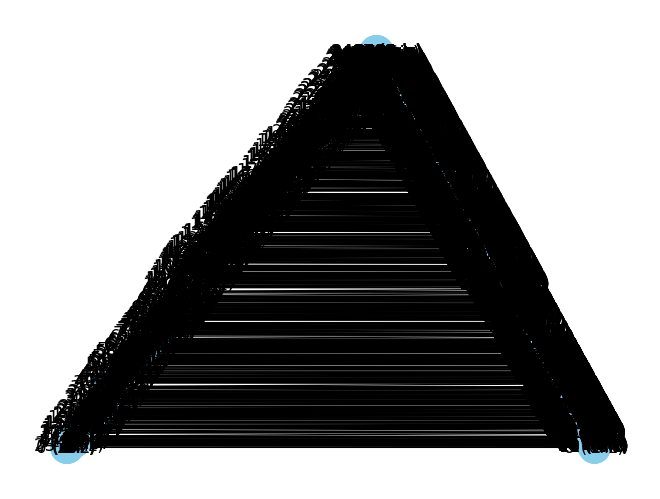

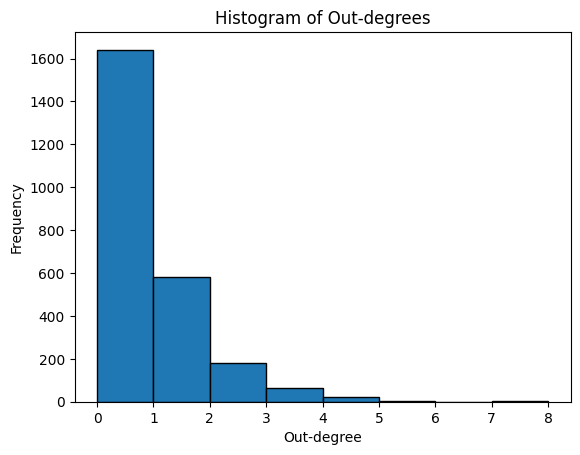

Média da distribuição dos graus de saída (mu):  0.5104


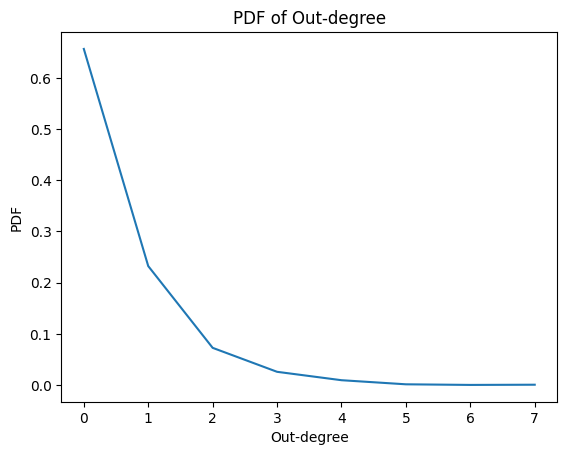

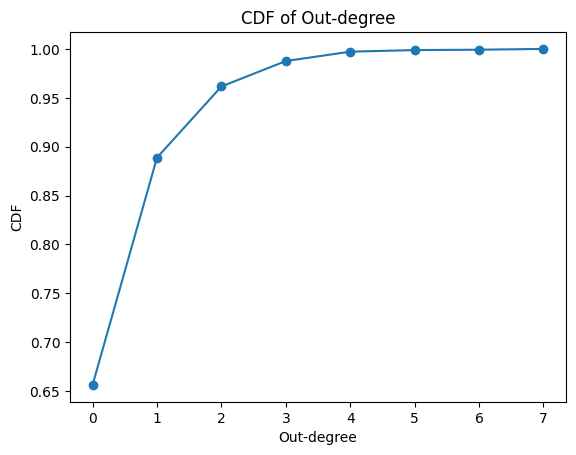

Total de ciclos ocupados 124577
Fração de ciclos ocupados 3114425.0
Total de periodos ociosos: 125423
Fração de periodos ociosos: 3135575.0


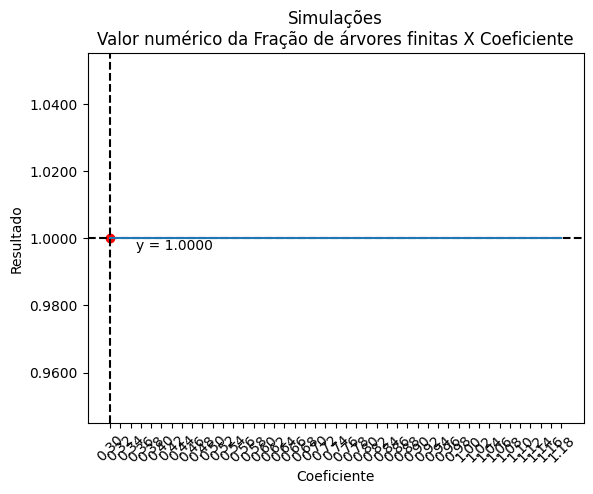

resultado analitico:1
[CORRETUDE] media do tempo de servico: 1240.6315770836147 - 1250.2129720999735
[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): 2487.9474411184547 - 2508.0982037403855
[CORRETUDE] Rho: 0.49856320903448537

estimador_grau_medio_saida_raiz (0.4979660482793181, 0.5079037392806472)

estimador_grau_medio_maximo_saida (7.508882058460282, 8.031117941539717)

estimador_altura_media_arvore (0.9303127084431824, 0.9475078868615598)

estimador_media_altura_nos (0.29395977367495657, 0.5422975917598452)

estimador_media_duracao_periodo_ocupado (0.6614322903118509, 1.323311890502719)

estimador_clientes_por_arvore (1.5225024024882934, 2.4622334626519597)

Valor analiticamente esperado de arvores finitas 1
Heurística simples:
Fração de arvores finitas 1.0
Intervalo de confianca (1.0, 1.0)

Algoritmo com Backtracking:
Fração de arvores finitas 1.0
intervalo de confianca: (1.0, 1.0)


In [82]:
clear_estimators()
print(f"caso exponencial ")
run_simulate_cenario1(tipo="e")

## deterministico


caso deterministico 


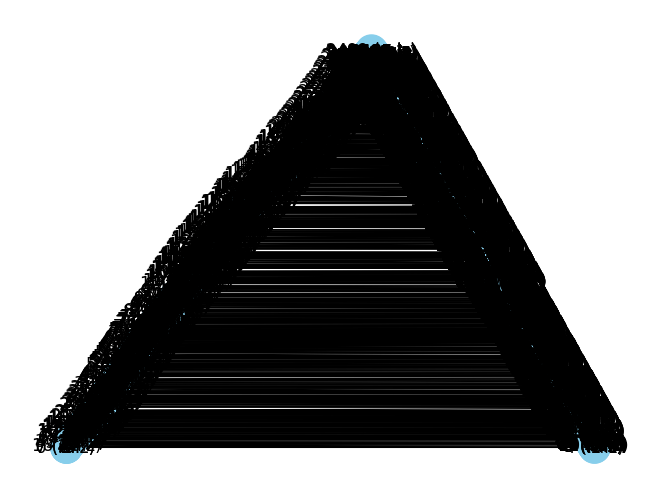

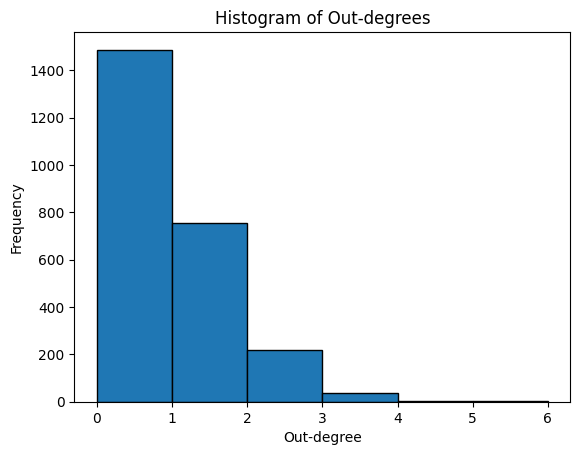

Média da distribuição dos graus de saída (mu):  0.5248


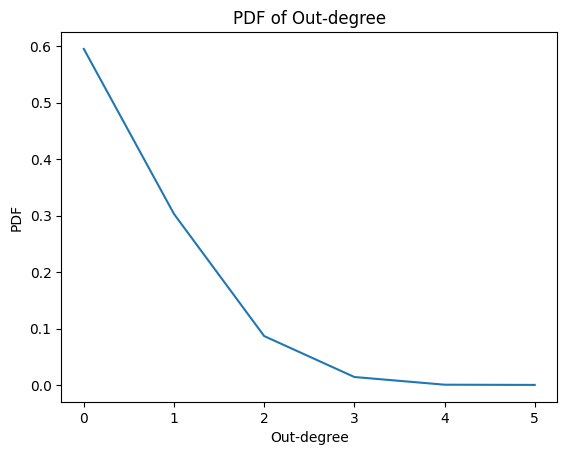

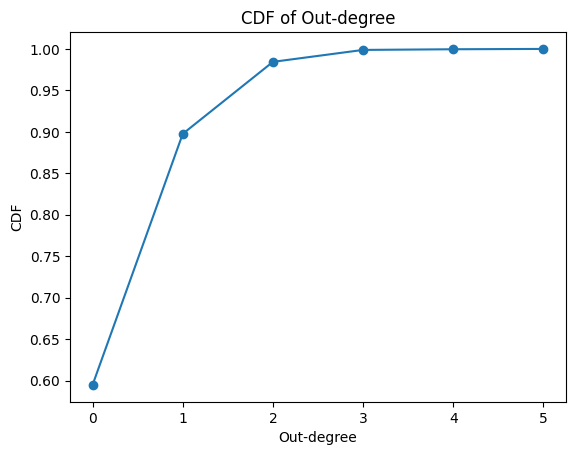

Total de ciclos ocupados 125299
Fração de ciclos ocupados 3132475.0
Total de periodos ociosos: 124701
Fração de periodos ociosos: 3117525.0


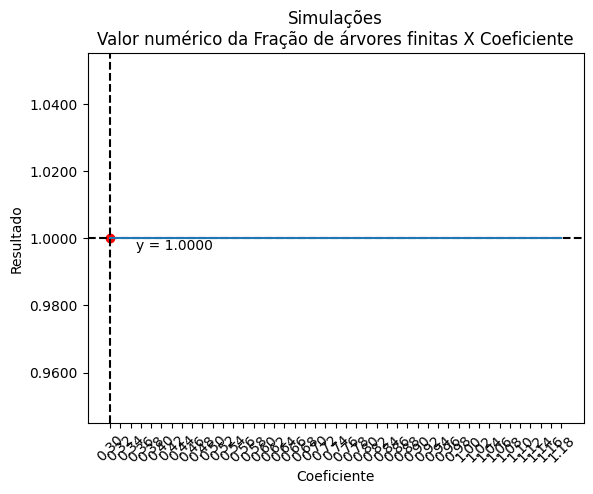

resultado analitico:1.0
[CORRETUDE] media do tempo de servico: 1250.0 - 1250.0
[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): 2482.837389868574 - 2502.083756472135
[CORRETUDE] Rho: 0.5015124465579922

estimador_grau_medio_saida_raiz (0.498935451940064, 0.507733877730249)

estimador_grau_medio_maximo_saida (4.990322050870503, 5.209677949129496)

estimador_altura_media_arvore (1.128178939246923, 1.1497403539758397)

estimador_media_altura_nos (0.37203799156517936, 0.6397967114490427)

estimador_media_duracao_periodo_ocupado (0.8063131471099093, 1.1979468942255886)

estimador_clientes_por_arvore (1.612217740032703, 2.395522582560866)

Valor analiticamente esperado de arvores finitas 1.0
Heurística simples:
Fração de arvores finitas 1.0
Intervalo de confianca (1.0, 1.0)

Algoritmo com Backtracking:
Fração de arvores finitas 1.0
intervalo de confianca: (1.0, 1.0)


In [83]:
clear_estimators()
print(f"caso deterministico ")
run_simulate_cenario1(tipo="d")

# Caso 2 - Fila MM1

p = 0.5

lambda = 2

mi = 4

In [84]:

def run_simulate_cenario2(tipo):
    # tipo: d ou e
    clear_estimators()
    simulate_trab2(N_RODADAS, MIN_CLIENTES, exp20, t_determinist_cenario_2 if tipo == "d" else exp40 )
    resultado_frac_arvores_finitas, ic= simple_heuristic_frac_finite_trees()
    coeficiente = monte_carlo_decision_of_coeficient(cenario=2, tipo=tipo)
    resultado_frac_arvores_finitas_backtracking, ic_backtracking = simple_heuristic_frac_finite_trees(MIN_CLIENTES * coeficiente)
    print_corretude()
    print(f"Valor analiticamente esperado de arvores finitas {get_resultado_analitico(2, tipo)}")
    print("Heurística simples:")
    print(f"Fração de arvores finitas {resultado_frac_arvores_finitas}")
    print("\nAlgoritmo com Backtracking:")
    print(f"Fração de arvores finitas {resultado_frac_arvores_finitas_backtracking}")
    print(f"intervalo de confianca: {ic_backtracking}")



##exponencial

caso exponencial 


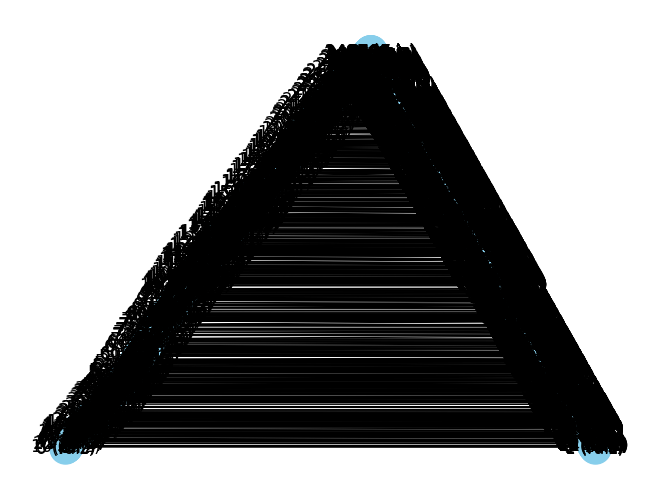

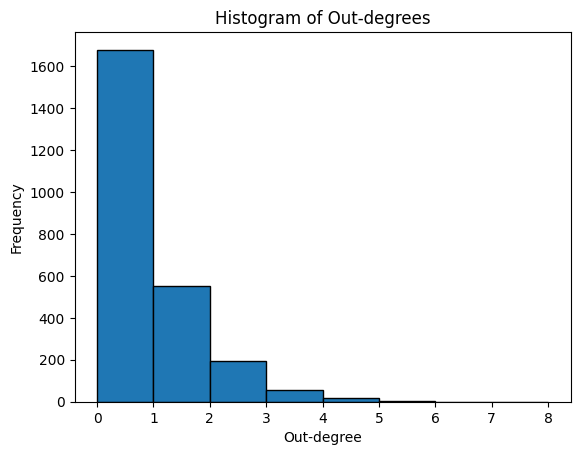

Média da distribuição dos graus de saída (mu):  0.4824140687450039


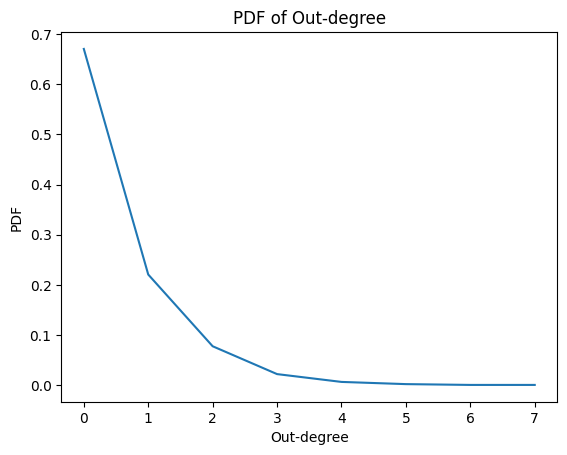

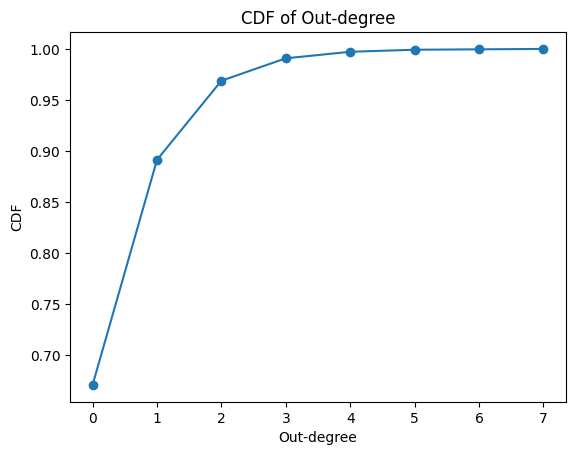

Total de ciclos ocupados 125114
Fração de ciclos ocupados 3127850.0000000005
Total de periodos ociosos: 124886
Fração de periodos ociosos: 3122149.9999999995


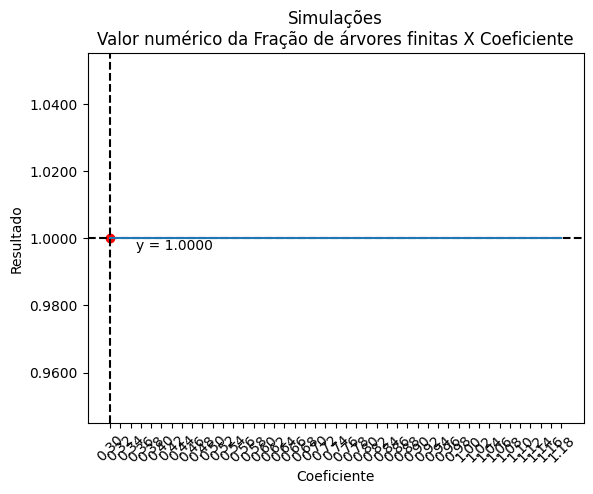

resultado analitico:1
[CORRETUDE] media do tempo de servico: 623.9994667115527 - 628.8432842192681
[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): 1245.4288359627083 - 1255.4056060524997
[CORRETUDE] Rho: 0.5009698882430866

estimador_grau_medio_saida_raiz (0.49740870083490846, 0.5066428854987113)

estimador_grau_medio_maximo_saida (7.387317079163392, 7.832682920836609)

estimador_altura_media_arvore (0.9348439622382245, 0.9513758625674213)

estimador_media_altura_nos (0.2945056254026379, 0.5444757147136139)

estimador_media_duracao_periodo_ocupado (0.33210306549639723, 0.670190460619198)

estimador_clientes_por_arvore (1.5216176741095035, 2.480958614434813)

Valor analiticamente esperado de arvores finitas 1
Heurística simples:
Fração de arvores finitas 1.0

Algoritmo com Backtracking:
Fração de arvores finitas 1.0
intervalo de confianca: (1.0, 1.0)


In [85]:
clear_estimators()
print(f"caso exponencial ")
run_simulate_cenario2(tipo="e")
#calc_ic(True)

## deterministico


caso deterministico 


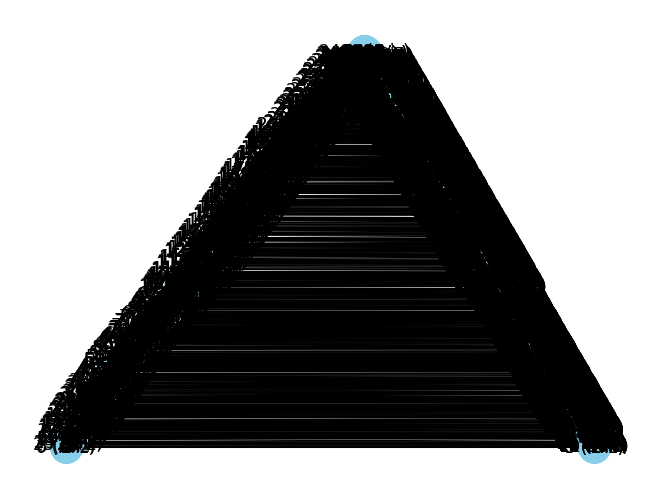

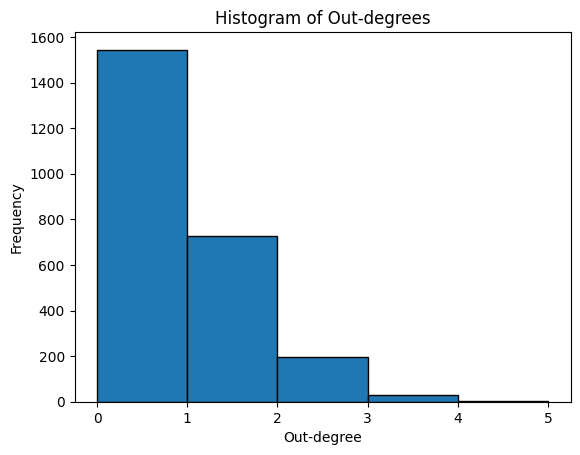

Média da distribuição dos graus de saída (mu):  0.4886045581767293


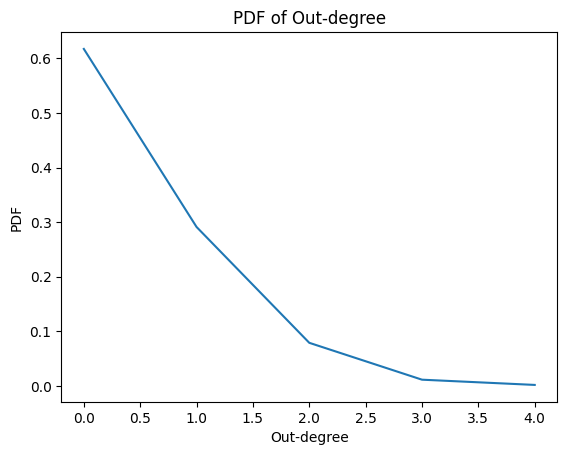

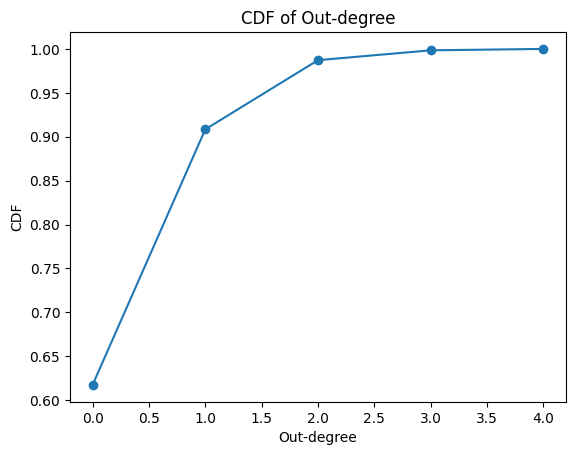

Total de ciclos ocupados 125402
Fração de ciclos ocupados 3135050.0
Total de periodos ociosos: 124598
Fração de periodos ociosos: 3114950.0


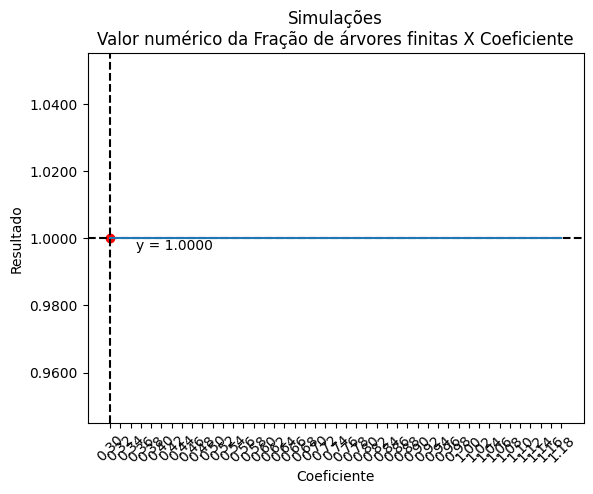

resultado analitico:1.0
[CORRETUDE] media do tempo de servico: 625.0 - 625.0
[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): 1239.6475213986482 - 1250.2592545691182
[CORRETUDE] Rho: 0.5020268276968544

estimador_grau_medio_saida_raiz (0.4974865598836395, 0.5055641967037166)

estimador_grau_medio_maximo_saida (5.104242625842765, 5.395757374157235)

estimador_altura_media_arvore (1.127625317179822, 1.147836592831931)

estimador_media_altura_nos (0.3714309600917707, 0.639435544470099)

estimador_media_duracao_periodo_ocupado (0.4027859703983319, 0.6002394761363763)

estimador_clientes_por_arvore (1.6107761298877863, 2.400483072344808)

Valor analiticamente esperado de arvores finitas 1.0
Heurística simples:
Fração de arvores finitas 1.0

Algoritmo com Backtracking:
Fração de arvores finitas 1.0
intervalo de confianca: (1.0, 1.0)


In [86]:
clear_estimators()
print(f"caso deterministico ")
run_simulate_cenario2(tipo="d")
#calc_ic(True)

# Caso 3 - Fila MM1

p = 1.05

lambda = 1.05

mi = 1

In [ ]:
def run_simulate_cenario3(tipo):
    # tipo: d ou e
    clear_estimators()
    random.seed(0)
    simulate_trab2(N_RODADAS, MIN_CLIENTES, lambda_exp105, t_determinist_cenario_3 if tipo == "d" else mu_exp10)
    resultado_frac_arvores_finitas, ic = simple_heuristic_frac_finite_trees()
    coeficiente = monte_carlo_decision_of_coeficient(cenario=3, tipo=tipo)
    # retroalimentaçao
    resultado_frac_arvores_finitas_backtracking, ic_backtracking = simple_heuristic_frac_finite_trees(MIN_CLIENTES * coeficiente)
    #
    print_corretude()
    print(f"Valor analiticamente esperado de arvores finitas {get_resultado_analitico(3, tipo)}")
    print("Heurística simples:")
    print(f"Fração de arvores finitas {resultado_frac_arvores_finitas}")
    print(f"intervalo de confianca: {ic}")
    print("\nAlgoritmo com Backtracking:")
    print(f"Fração de arvores finitas {resultado_frac_arvores_finitas_backtracking}")
    print(f"intervalo de confianca: {ic_backtracking}")



## exponencial

caso exponencial 


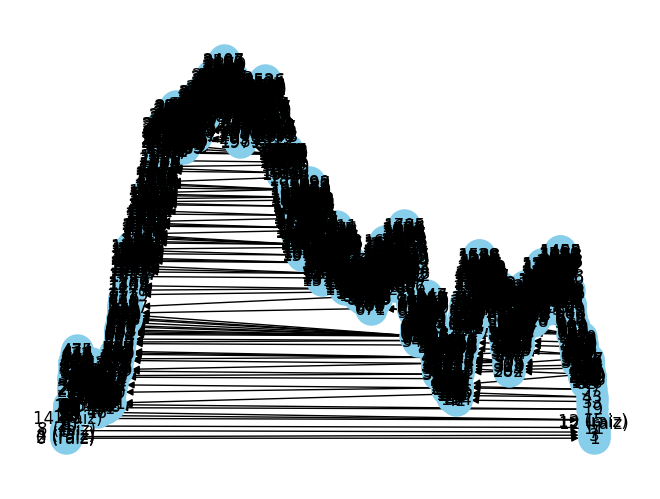

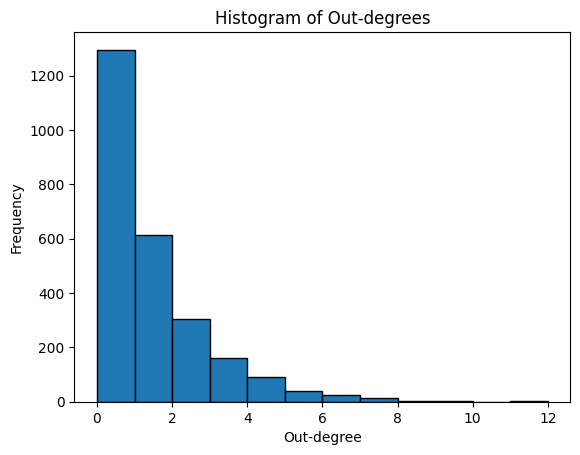

Média da distribuição dos graus de saída (mu):  0.9972495088408643


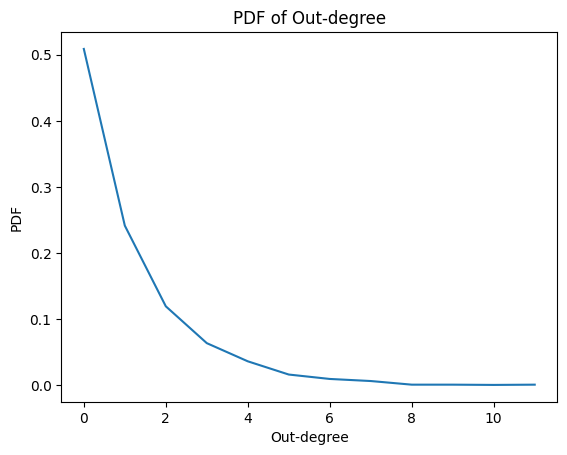

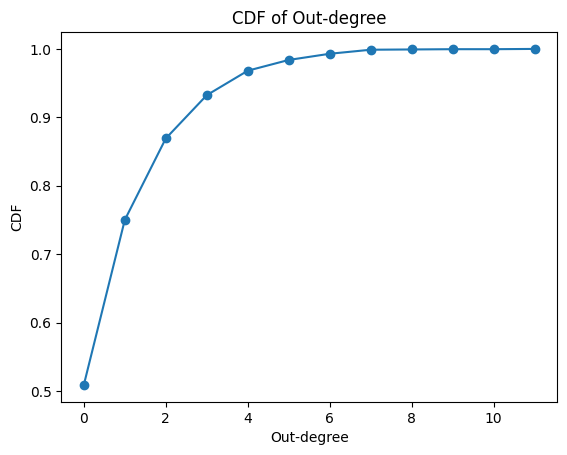

Total de ciclos ocupados 248101
Fração de ciclos ocupados 6202525.000000001
Total de periodos ociosos: 1899
Fração de periodos ociosos: 47474.99999999999


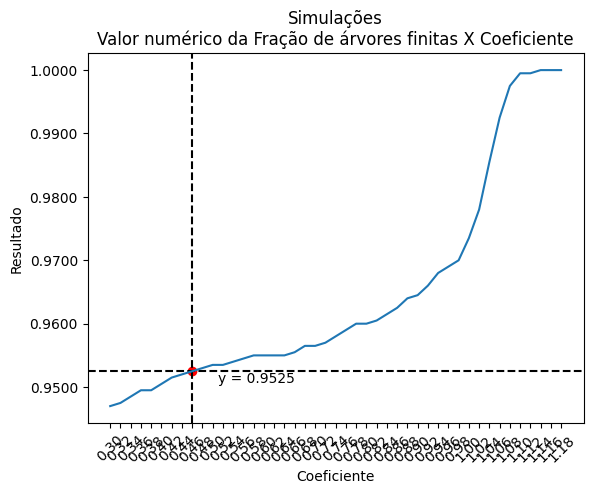

resultado analitico:0.9523809523809523
[CORRETUDE] media do tempo de servico: 2489.3716672211176 - 2506.961469050014
[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): 2509.553821208922 - 2525.3018200805504
[CORRETUDE] Rho: 0.9923488362402234

estimador_grau_medio_saida_raiz (1.0694938580284457, 1.3663488977705276)

estimador_grau_medio_maximo_saida (12.745021818272953, 13.534978181727048)

estimador_altura_media_arvore (8.040659409126526, 12.09949788285623)

estimador_media_altura_nos (1.1279082848992212, 2.940829910598697)

estimador_media_duracao_periodo_ocupado (-0.45415512103076594, 38.77504311731614)

estimador_clientes_por_arvore (31.04316375697458, 232.8277717107593)

Valor analiticamente esperado de arvores finitas 0.9523809523809523
Heurística simples:
Fração de arvores finitas 0.9644822411205602
intervalo de confianca: (0.9634258511803555, 0.965538631060765)

Algoritmo com Backtracking:
Fração de arvores finitas 0.9524762381190596
intervalo de con

In [87]:
print(f"caso exponencial ")
run_simulate_cenario3(tipo="e")

## deterministico

caso deterministico   


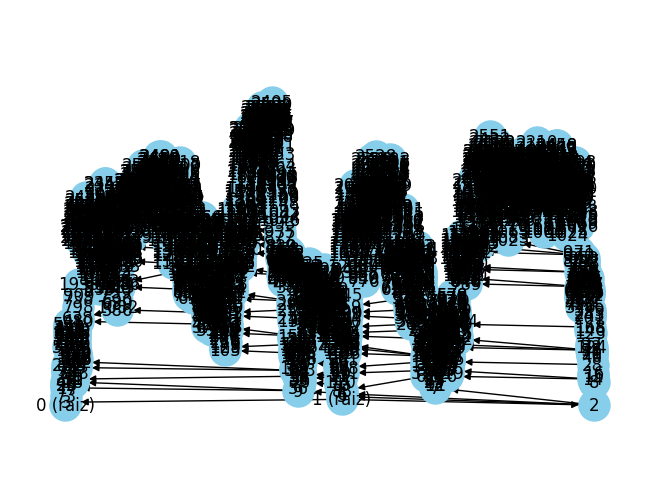

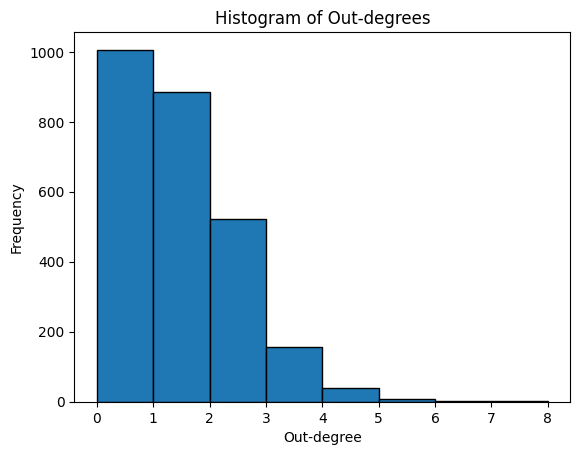

Média da distribuição dos graus de saída (mu):  0.9992363497518139


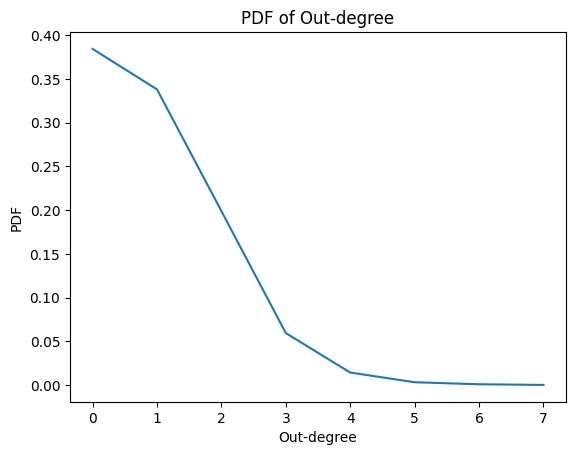

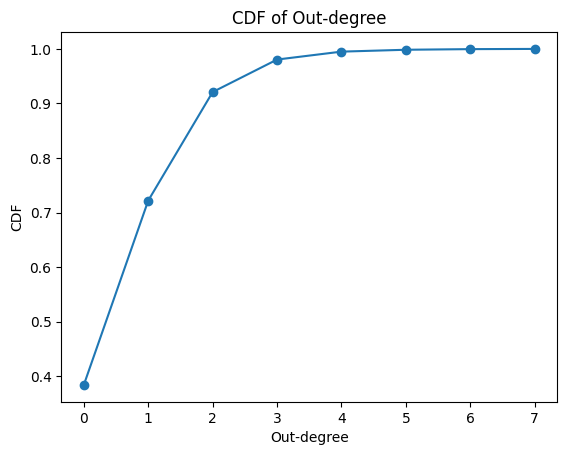

Total de ciclos ocupados 249134
Fração de ciclos ocupados 6228350.0
Total de periodos ociosos: 866
Fração de periodos ociosos: 21650.0


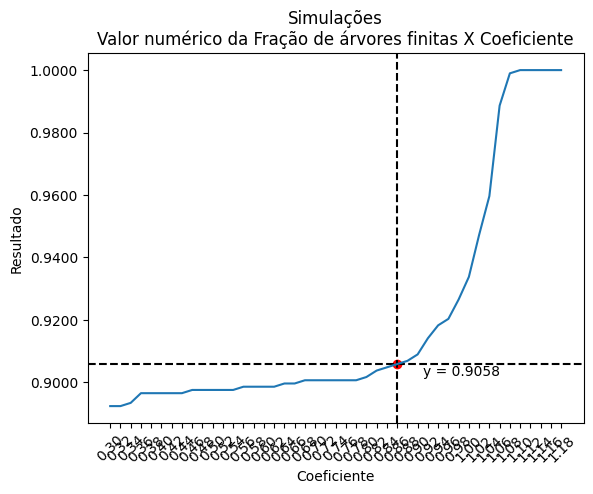

resultado analitico:0.9062981629270974
[CORRETUDE] media do tempo de servico: 2500.0 - 2500.0
[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): 2507.620827659531 - 2510.8014588467445
[CORRETUDE] Rho: 0.9963290680906208

estimador_grau_medio_saida_raiz (1.137365780675163, 1.3495217077136419)

estimador_grau_medio_maximo_saida (7.045243033837542, 7.294756966162458)

estimador_altura_media_arvore (17.339484790357822, 25.555560541990147)

estimador_media_altura_nos (2.5798143525654806, 5.77031541792912)

estimador_media_duracao_periodo_ocupado (1.9339480503003337, 38.85814652190717)

estimador_clientes_por_arvore (124.42600343361269, 420.3069158210458)

Valor analiticamente esperado de arvores finitas 0.9062981629270974
Heurística simples:
Fração de arvores finitas 0.9089026915113871
intervalo de confianca: (0.9014532414019378, 0.9163521416208364)

Algoritmo com Backtracking:
Fração de arvores finitas 0.9057971014492754
intervalo de confianca: (0.89843897761496

In [89]:
print(f"caso deterministico   ")
run_simulate_cenario3(tipo="d")

# Caso 4 - Fila MM1

p = 1.10

lambda = 1.10

mi = 1

In [90]:
def run_simulate_cenario4(tipo):
    # tipo: d ou e
    random.seed(0)
    clear_estimators()
    simulate_trab2(N_RODADAS, MIN_CLIENTES, lambda_exp110, t_determinist_cenario_4 if tipo == "d" else mu_exp10 )
    resultado_frac_arvores_finitas, ic = simple_heuristic_frac_finite_trees()
    coeficiente = monte_carlo_decision_of_coeficient(cenario=4, tipo=tipo)
        # retroalimentaçao
    resultado_frac_arvores_finitas_backtracking, ic_backtracking = simple_heuristic_frac_finite_trees(MIN_CLIENTES * coeficiente)
    #

    print_corretude()
    print(f"Valor analiticamente esperado de arvores finitas {get_resultado_analitico(4, tipo)}")
    print("Heurística simples:")
    print(f"Fração de arvores finitas {resultado_frac_arvores_finitas}")
    print(f"intervalo de confianca: {ic}")
    print("Algoritmo com Backtracking:")
    print(f"Fração de arvores finitas {resultado_frac_arvores_finitas_backtracking}")
    print(f"intervalo de confianca: {ic_backtracking}")
    print(f"Valor analiticamente esperado de arvores finitas {get_resultado_analitico(4, tipo)}")


## exponencial

caso exponencial 


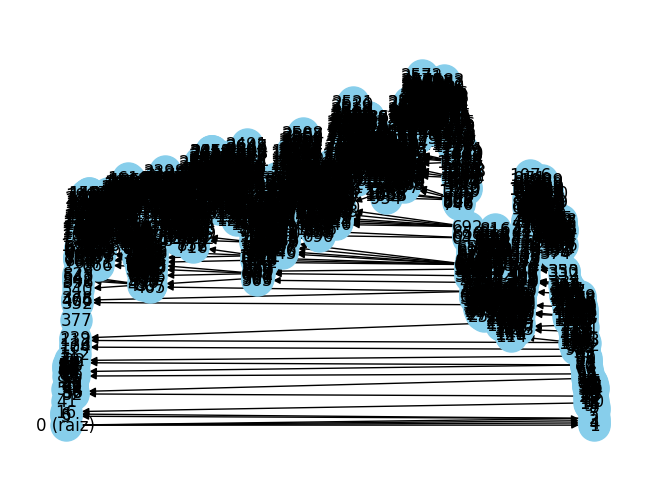

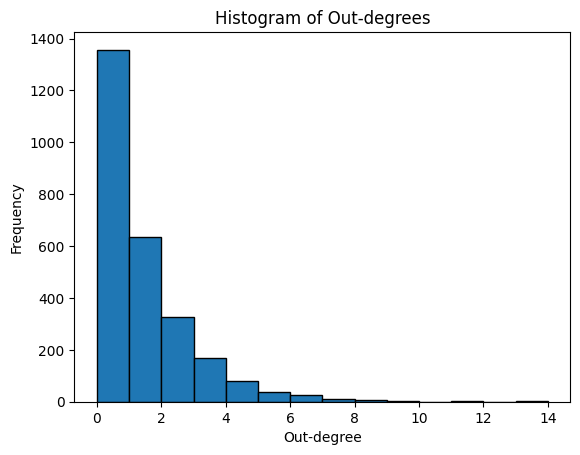

Média da distribuição dos graus de saída (mu):  0.9996233521657252


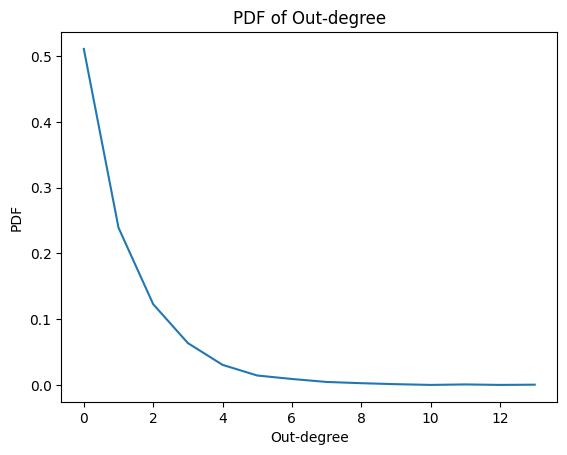

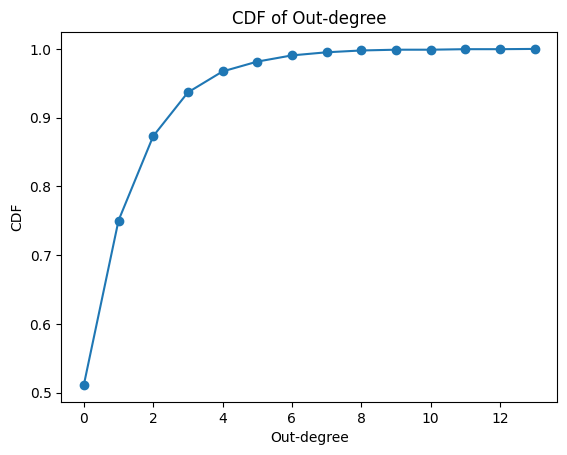

Total de ciclos ocupados 248789
Fração de ciclos ocupados 6219725.0
Total de periodos ociosos: 1211
Fração de periodos ociosos: 30275.0


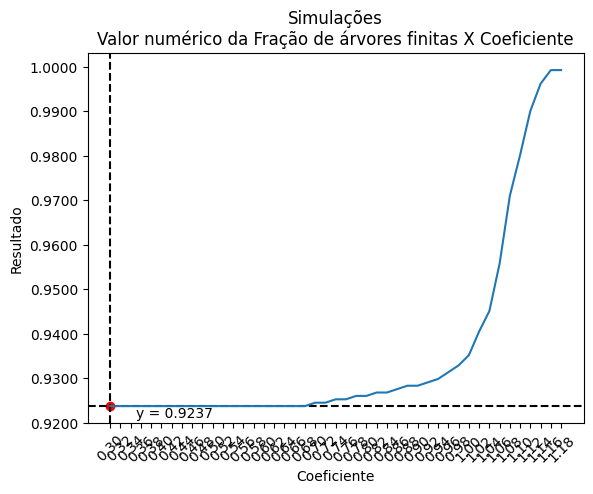

resultado analitico:0.9090909090909091
[CORRETUDE] media do tempo de servico: 2485.111767428198 - 2504.8338367703323
[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): 2496.966305744079 - 2516.2594092444747
[CORRETUDE] Rho: 0.9953562611951782

estimador_grau_medio_saida_raiz (1.2018892957666492, 1.516352087362635)

estimador_grau_medio_maximo_saida (13.076892113525464, 13.823107886474535)

estimador_altura_media_arvore (8.938867765490473, 13.322796766534855)

estimador_media_altura_nos (1.2311578207398963, 3.067684043749006)

estimador_media_duracao_periodo_ocupado (1.6048493514815556, 16.809565694315086)

estimador_clientes_por_arvore (72.77748480380305, 346.43685539451883)

Valor analiticamente esperado de arvores finitas 0.9090909090909091
Heurística simples:
Fração de arvores finitas 0.9282990083905416
intervalo de confianca: (0.9263117900633941, 0.930286226717689)
Algoritmo com Backtracking:
Fração de arvores finitas 0.92372234935164
intervalo de confia

In [91]:
print(f"caso exponencial ")
run_simulate_cenario4(tipo="e")

## deterministico

caso deterministico 


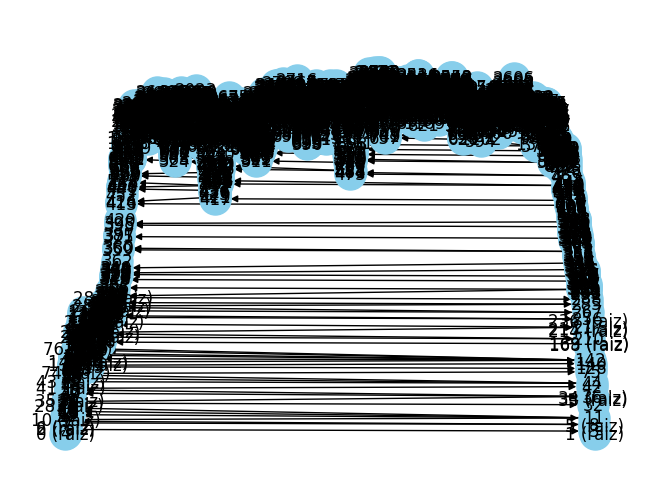

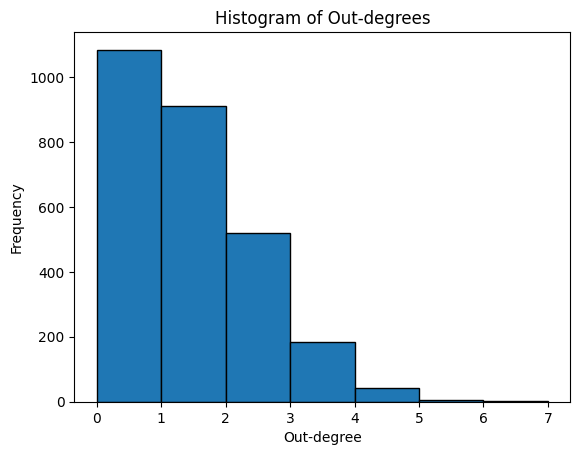

Média da distribuição dos graus de saída (mu):  0.9901925172539048


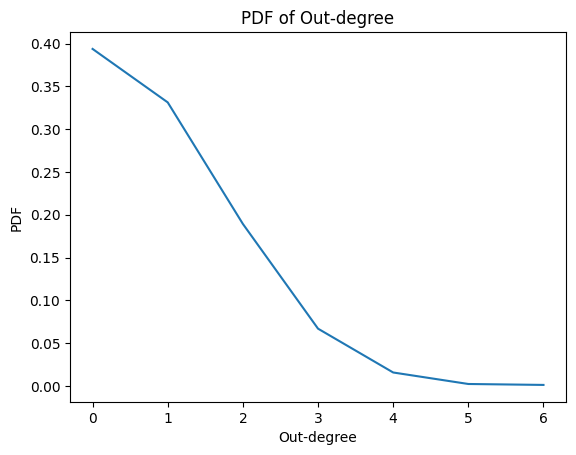

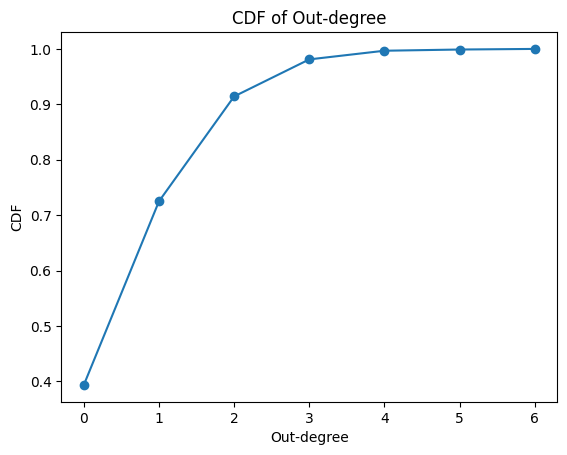

Total de ciclos ocupados 249579
Fração de ciclos ocupados 6239475.0
Total de periodos ociosos: 421
Fração de periodos ociosos: 10525.0


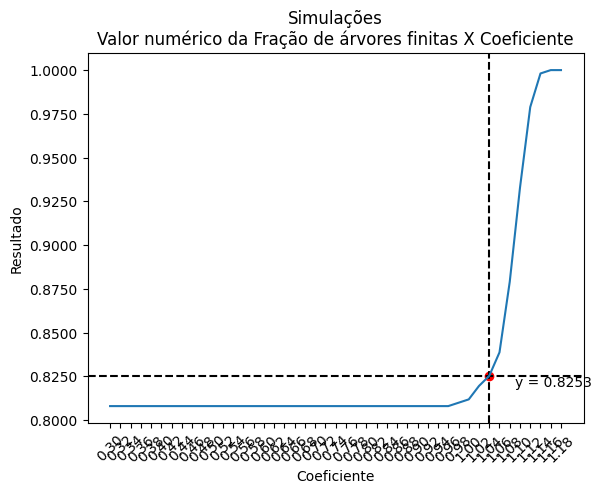

resultado analitico:0.8238658563681878
[CORRETUDE] media do tempo de servico: 2500.0 - 2500.0
[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): 2503.9235727085966 - 2505.8195963205203
[CORRETUDE] Rho: 0.9980551559829752

estimador_grau_medio_saida_raiz (1.2538101689833838, 1.549213957217213)

estimador_grau_medio_maximo_saida (7.15516529878971, 7.404834701210291)

estimador_altura_media_arvore (18.376479139049543, 24.776316183275178)

estimador_media_altura_nos (3.311431006410622, 6.250791701545683)

estimador_media_duracao_periodo_ocupado (4.926888070302479, 12.842813334374334)

estimador_clientes_por_arvore (318.87482312111166, 737.274888971019)

Valor analiticamente esperado de arvores finitas 0.8238658563681878
Heurística simples:
Fração de arvores finitas 0.8080614203454894
intervalo de confianca: (0.7934318742511869, 0.822690966439792)
Algoritmo com Backtracking:
Fração de arvores finitas 0.8253358925143954
intervalo de confianca: (0.8103759649203062,

In [92]:
print(f"caso deterministico ")
run_simulate_cenario4(tipo="d")
#calc_ic(True)

#GAMBLERS RUIN


In [ ]:
def simulate2(
    rounds,
    qeue_max_size,
    arrival_dist,
    service_dist,
    time_max_round
):

    # start up sistema
    t = 0.0
    nqueue = 0  #
    client_in_server = None

    # sistema começa com 1 chegada
    client_id = 0  # ID inicial dos clientes
    first_arrival = generate_arrival(t, arrival_dist, client_id)
    client_id += 1

    # Cria a lista de eventos, com o evento inicial
    events_list = EventsList()
    events_list.add(first_arrival)

    clients_queue = ClientsQueue()  # Cria a fila de espera de clientes, vazia

    # Quantidade de vezes que jogador faliu
    empty_queue_ocurrences = 0
    expected_time_to_ruin = 0
    expected_steps_to_ruin = 0

    # Quantidade de vezes que jogador chegou no sucesso
    full_queue_ocurrences = 0
    expected_time_to_win = 0
    expected_steps_to_win = 0

    for i in range(rounds):
        # Numero de clientes servidos na rodada
        served_clients = 0

        nqueue = 0 # zerando tamanho da fila
        n_atendimentos = 0

        n_clients_current = [] # clientes na fila por rodada

        # Conta o # de passos e o tempo ate terminar o jogo na rodada (ruin or win)
        round_time = 0
        steps = 0

        while round_time < time_max_round:

            # Seleciona o próximo evento e tira da lista
            event = events_list.pop()

            # Soma o passsos e time do GAMBLERS RUIN
            round_time += (event.t - t)
            steps += 1

            # Avança o tempo para o instante do evento
            t = event.t

            if event.event_type == ARRIVAL:
                new_client = create_client(event) # Cria um cliente

                if not client_in_server:
                    client_in_server = new_client # Coloca o cliente no servidor
                    serve_client(new_client, t, service_dist, events_list)  # Registra tempo de espera e adiciona evento do fim do serviço na lista

                else: # Se o servidor esta OCUPADO
                    clients_queue.add(new_client) # Adiciona o cliente na fila de espera
                    nqueue += 1 # Incrementa numero de clientes na fila de espera

                    if nqueue == qeue_max_size:
                        full_queue_ocurrences += 1
                        expected_time_to_win += round_time
                        expected_steps_to_win += steps
                        break

                new_arrival = generate_arrival(t, arrival_dist, client_id) # Cria nova chegada
                client_id += 1 # Incrementa id de cliente
                events_list.add(new_arrival)  # Adiciona nova chegada na lista de eventos
            else:
                served_clients += 1

                # NINGUEM na fila de espera
                if nqueue == 0:
                    client_in_server = None

                    empty_queue_ocurrences += 1
                    expected_time_to_ruin += round_time
                    expected_steps_to_ruin += steps
                    break

                else: # Se ha ALGUEM na fila de espera
                    client = clients_queue.pop()
                    client_in_server = client # Coloca o cliente no servidor
                    serve_client(client, t, service_dist, events_list)  # Registra tempo de espera e adiciona evento do fim do serviço na lista
                    nqueue -= 1 # Decrementa numero de clientes na fila de espera

            n_clients_current.append(nqueue)

        # zerando tempo de simulação e lista de eventos/clientes para próxima rodada
        client_in_server = None
        client_id = 0
        t = 0
        clients_queue.clear()
        events_list.clear()
        events_list.add(generate_arrival(t, arrival_dist, client_id))
        client_id += 1

    return {
        "empty_queue_ocurrences": empty_queue_ocurrences,
        "expected_time_to_ruin": expected_time_to_ruin,
        "expected_steps_to_ruin": expected_steps_to_ruin,
        "full_queue_ocurrences": full_queue_ocurrences,
        "expected_time_to_win": expected_time_to_win,
        "expected_steps_to_win": expected_steps_to_win
    }

### Resolve Transformada da Exponencial

In [ ]:
def resolve_equacao_exponencial(s):
    x_values = np.linspace(0, 4, 400) # Discretização mais precisa
    integral_value = np.trapz(np.exp(-(_LAMBDA) * x_values * ((_MI) - s)) * np.exp(-(_MI) * x_values), x_values)
    return s - integral_value

###Caso 3

In [ ]:
def exp10():
  return generate_exp(1.0)

def exp105():
  return generate_exp(1.05)

LAMBDA = exp105

MU = exp10

QUEUE_MAX_SIZE = 4

N_RODADAS_GAMBLERS_RUIN = 40

TIME_MAX_ROUND = 100000

valores = simulate2(N_RODADAS_GAMBLERS_RUIN, QUEUE_MAX_SIZE, LAMBDA, MU, TIME_MAX_ROUND)


prob_time_ruin = valores["expected_time_to_ruin"]/valores["empty_queue_ocurrences"]
prob_steps_ruin = valores["expected_steps_to_ruin"]/valores["empty_queue_ocurrences"]
prob_ruin = valores["empty_queue_ocurrences"]/N_RODADAS_GAMBLERS_RUIN

prob_time_win = valores["expected_time_to_win"]/valores["full_queue_ocurrences"]
prob_steps_win = valores["expected_time_to_win"]/valores["full_queue_ocurrences"]
prob_win = valores["full_queue_ocurrences"]/N_RODADAS_GAMBLERS_RUIN

print(f"""Fração de ruinas: {prob_ruin}""")
print(f"""Fração tempo até a ruina: {prob_time_ruin:.5f}""")
print(f"""Fração de passos até a ruina: {prob_steps_ruin:.5f}""")

print(f"""\nFração de fortuna: {prob_win}""")
print(f"""Fração tempo até a fortuna: {prob_time_win:.5f}""")
print(f"""Fração de passos até a fortuna: {prob_steps_win:.5f}""")

Fração de ruinas: 0.775
Fração tempo até a ruina: 2.33308
Fração de passos até a ruina: 3.80645

Fração de fortuna: 0.225
Fração tempo até a fortuna: 4.89647
Fração de passos até a fortuna: 4.89647


In [ ]:
# Caso 3
_LAMBDA = 1.05
_MI = 1

# Suposição inicial para s
initial_guess = 0.5

s_solution = fsolve(resolve_equacao_exponencial, initial_guess)

print(f"Menor solução encontrada: {s_solution[0]}")

Menor solução encontrada: 0.8724359725563777


###Caso 4

In [ ]:
def exp10():
  return generate_exp(1.0)

def exp110():
  return generate_exp(1.10)

LAMBDA = exp110

MU = exp10

QUEUE_MAX_SIZE = 4

N_RODADAS_GAMBLERS_RUIN = 40

TIME_MAX_ROUND = 100000

valores = simulate2(N_RODADAS_GAMBLERS_RUIN, QUEUE_MAX_SIZE, LAMBDA, MU, TIME_MAX_ROUND)

prob_time = valores["expected_time_to_ruin"]/valores["empty_queue_ocurrences"]
prob_steps = valores["expected_steps_to_ruin"]/valores["empty_queue_ocurrences"]
prob_ruin = valores["empty_queue_ocurrences"]/N_RODADAS_GAMBLERS_RUIN

prob_time_win = valores["expected_time_to_win"]/valores["full_queue_ocurrences"]
prob_steps_win = valores["expected_time_to_win"]/valores["full_queue_ocurrences"]
prob_win = valores["full_queue_ocurrences"]/N_RODADAS_GAMBLERS_RUIN

print(f"""Fração de ruinas: {prob_ruin}""")
print(f"""Fração tempo até a ruina: {prob_time_ruin:.5f}""")
print(f"""Fração de passos até a ruina: {prob_steps_ruin:.5f}""")

print(f"""\nFração de fortuna: {prob_win}""")
print(f"""Fração tempo até a fortuna: {prob_time_win:.5f}""")
print(f"""Fração de passos até a fortuna: {prob_steps_win:.5f}""")

Fração de ruinas: 0.675
Fração tempo até a ruina: 2.33308
Fração de passos até a ruina: 3.80645

Fração de fortuna: 0.325
Fração tempo até a fortuna: 4.86165
Fração de passos até a fortuna: 4.86165


In [ ]:
# Caso 4
_LAMBDA = 1.10
_MI = 1

# Suposição inicial para s
initial_guess = 0.5

s_solution = fsolve(resolve_equacao_exponencial, initial_guess)

print(f"Menor solução encontrada: {s_solution[0]}")

Menor solução encontrada: 0.8510895174716843
